In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#Adapted from: 
# lqr_neural_error_dynamics.ipynb

import scipy.io as sio
import scipy.stats as sio_stat
import scipy.interpolate
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt 

import os
import pickle
import sys
import copy

import time
import pylab as pl
from IPython import display

from bmi_dynamics_code import behavior_co_obs as bmi_b
from bmi_dynamics_code import data_for_v as preeyacode
from bmi_dynamics_code import util as bmi_util

import timeit
from sklearn import decomposition as skl_decomp

import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge

%matplotlib notebook

In [3]:
%matplotlib notebook

In [4]:
# set the colormap and centre the colorbar
import matplotlib.colors as colors
class MidpointNormalize(colors.Normalize):
    """
    Normalise the colorbar so that diverging bars work there way either side from a prescribed midpoint value)

    e.g. im=ax1.imshow(array, norm=MidpointNormalize(midpoint=0.,vmin=-100, vmax=100))
    """
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y), np.isnan(value))

In [5]:
# data_dir = '/Users/vivekathalye/Dropbox/Code/preeya_co_obstacle'
save_dir = r'D:\Dropbox\BMI_co_obs_paper\data\vivek\lqr'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
ext_list =['.png', '.eps']

home_dir = r'D:\Dropbox\Code\preeya_co_obstacle'
data_dir = r'D:\Dropbox\Data\preeya_co_obstacle'
data_path = os.path.join(data_dir, 'for_v_df.pkl')
print(os.path.exists(data_path))
d = pickle.load(open(data_path))

#UNPACK: 
decoder = d['decoder']
pre = d['pre']
num_targets = d['num_targets']
sample_period = d['sample_period']
target_hold_time = d['target_hold_time']
num_neurons = d['num_neurons']
target_color = d['target_color']
obs_big = d['obs_big']
obs_small = d['obs_small']
target_r_task = d['target_r_task'] #target_r_task = {0:1.7, 1:2.0}
cursor_r = d['cursor_r']
target_r_eff = d['target_r_eff']
target_pos = d['target_pos']
target_angle = np.arctan2(target_pos[:,1], target_pos[:,0])
target_dist = np.linalg.norm(target_pos, axis=1)
obs_pos = d['obs_pos']

tc_meta = d['tc_meta']
task_list = d['task_list']
num_tasks = len(task_list)
task2idx = d['task2idx']
idx2task = bmi_util.invert_dic(task2idx)
task2tc = d['task2tc']
tc_list = d['tc_list']
df = d['df']
df_label = d['df_label']

task_color = ['k', 'r']

#Pre-processing: 

bmi_b.preprocess_bmi_df(df, target_pos, pre, num_tasks, num_targets)
num_cw = 2
cw_label = ['cw', 'ccw']
task_rot_list = [0,1.1,1.2]

#Binning: 
#MAGNITUDE:
num_mag_bins = 5
num_mag_bins_analyze = 4
# mag_bin_perc = np.array([0,25,50,75,100])
mag_bin_perc = np.concatenate([np.linspace(0,95,5),np.array([100])])
#ANGLE:
num_angle_bins = 8
T0_angle = -3*(2*np.pi)/8
mag_bin, mag_bin_edges, mag_bin_c, angle_bin_c, angle_bin, angle_bin_edges =\
bmi_b.def_command_bin(df, mag_bin_perc, num_angle_bins, T0_angle)
#CENTER ANGLE DATA FOR BINNING (based on bin boundaries): 
angle_center_for_binning = bmi_b.df_center_angle_for_binning(df, angle_bin)
#BIN: 
bmi_b.df_bin_command(df, mag_bin_edges,angle_bin_edges)

#Pre-processing continued:

#Center angles to command bin, target: 
bmi_b.center_df_angle(df, angle_bin_c, target_angle)

True
('angle_center:', 22.5)
('min centered angle:', -157.47162455426732)
('max centered angle:', 202.46708261619673)


<IPython.core.display.Javascript object>


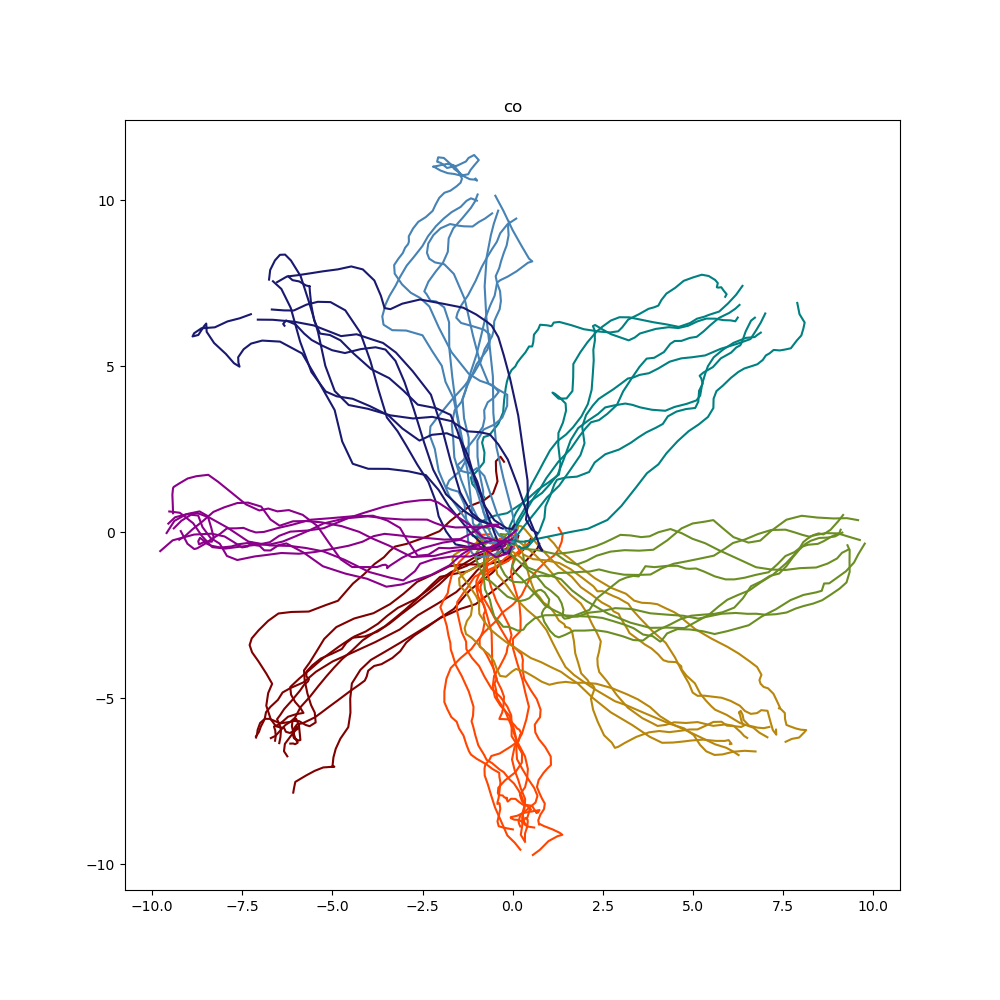

<IPython.core.display.Javascript object>


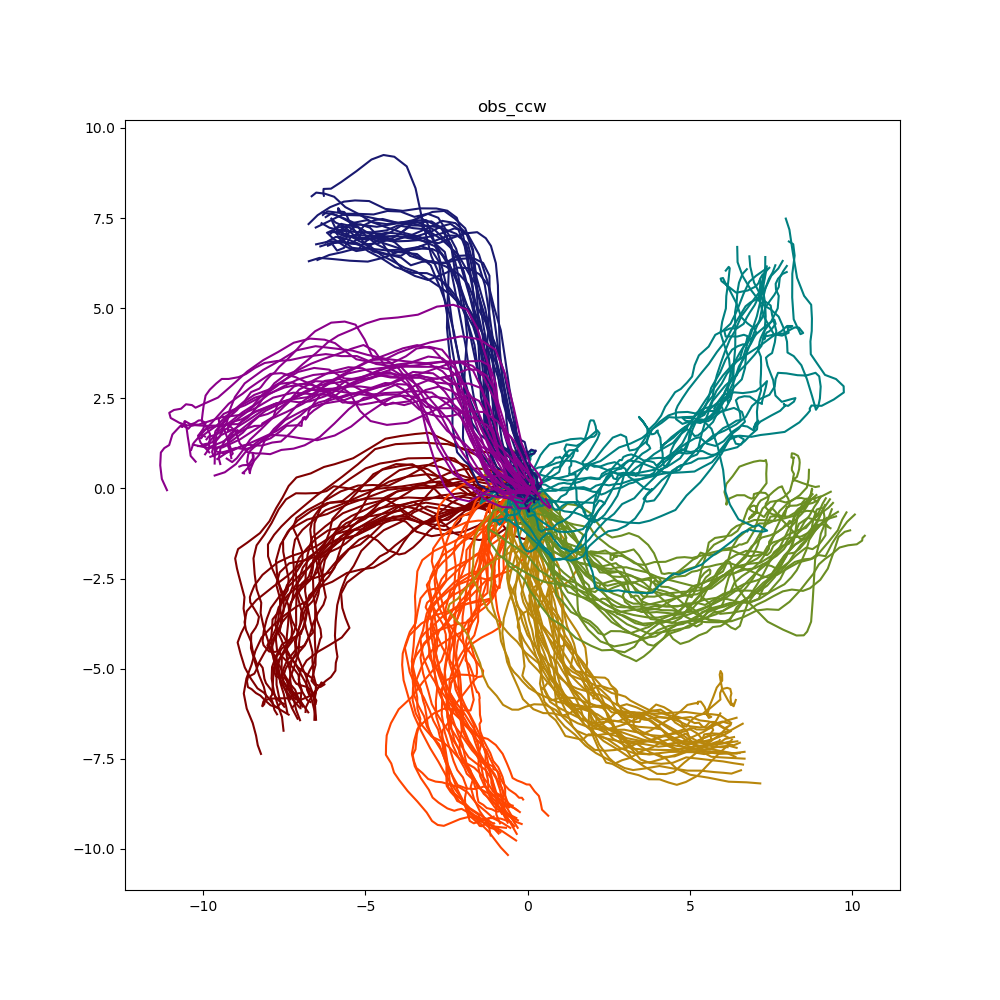

<IPython.core.display.Javascript object>


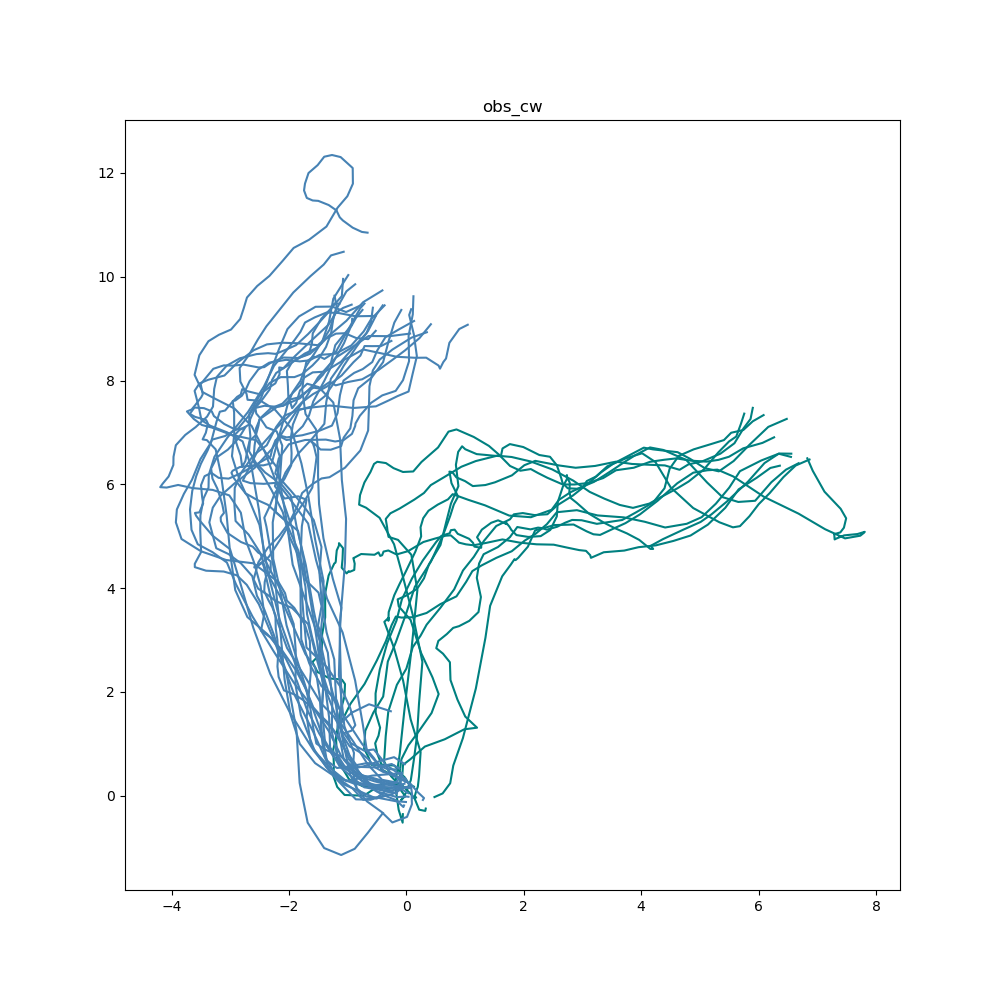

In [6]:
#Plot cw vs ccw trials, to confirm: 
plot = {}
plot['size'] = (10,10)
plot['xlim'] = (-12.5,12.5)
plot['ylim'] = (-12.5,12.5)
task_rot_list = [0,1.1,1.2]
task_rot_label = ['co','obs_ccw', 'obs_cw']

for i,task in enumerate(task_rot_list):
    plt.figure(figsize=plot['size'])
    plt.title(task_rot_label[i])
    for target in range(num_targets):    
            sel = (df['task_rot']==task) & (df['bin']>=0) & (df['target']==target)
            df_sel = df[sel]
            #------------------------------------------------------------------------------------
            #TRIALS: 
            trial_start = np.where(df_sel['bin']==0)[0]
            trial_stop = np.where(df_sel['bin_end']==0)[0]
            trial_bound = np.vstack((trial_start,trial_stop)).T
            #------------------------------------------------------------------------------------
            for bnd in trial_bound[:,:]: #trial_bound[0:1,:]:
    #             if (task_str == 'co') or (task_str == 'obs') and (df_sel['obs_size'][bnd[0]:bnd[0]+1] == obs_big).bool(): 
                x = df_sel['kin_px'][bnd[0]:bnd[1]+1]
                y = df_sel['kin_py'][bnd[0]:bnd[1]+1]
                color = target_color[target]
                plt.plot(x,y,'-',color=color)

4704     115.0
4755     116.0
4796     117.0
4842     118.0
4890     119.0
4941     120.0
4988     121.0
5046     122.0
5122     123.0
5392     127.0
10206    238.0
Name: trial_global, dtype: float64


<IPython.core.display.Javascript object>


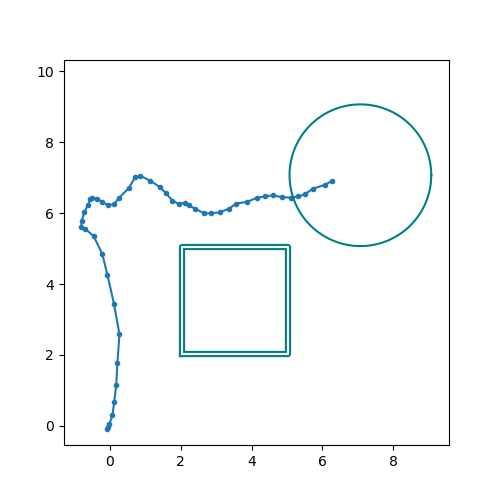

(-1.3012247717787875,
 9.564986506324725,
 -0.5427594616898825,
 10.32345181641363)

In [7]:
target = 4
sel_target = (df['target']==target)
sel_start = (df['bin']==0)
sel_task = (df['task_rot']==1.2) #1.2 is clockwise, 1.1 is counterclockwise
sel = sel_target&sel_start&sel_task
trials = df.loc[sel,'trial_global']
print(trials)

trial = int(trials.iloc[0])
sel_trial = (df['trial_global']==trial)
sel_bin = (df['bin']>=0)
sel = sel_trial&sel_bin

x = df.loc[sel, 'kin_px']
y = df.loc[sel, 'kin_py']

plt.figure(figsize=(5,5))
plt.plot(x,y, '.-')
c = target_color[target]
bmi_util.plot_obstacles(obs_pos[target,:].reshape((1,-1)), [c], obs_big*np.ones(1))
bmi_util.plot_targets(target_pos[target,:].reshape((1,-1)), [c], target_r_task[1]*np.ones(1))
plt.axis('square')

### Load noisy lqr sim data

In [ ]:
#Past analyzed files
# save_path = os.path.join(save_dir, 'lqr_noise_1000trials.pkl')
# save_path = os.path.join(r'D:\DATA\bmi_co_obs_backup', 'lqr_noise_1000trials_expt_noise_diag.pkl')
# save_path = os.path.join(r'D:\DATA\bmi_co_obs_backup', 'lqr_noise_20trials_noise_diag_expt_psth.pkl')

In [8]:
save_path = os.path.join(r'D:\DATA\bmi_co_obs_backup', 'lqr_noise_20trials_noise_diag_from_noiseless_n_null_lqr.pkl')
with open(save_path, 'rb') as f: 
    r = pickle.load(f)
#Note the simulations were run with neural activity initialized to 0    
for (k,v) in r.items():
    exec(k+'=v')

<IPython.core.display.Javascript object>


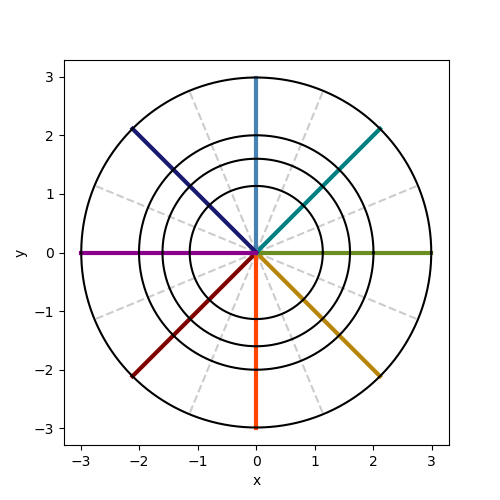

In [9]:
num_mag_bins_analyze=4
def plot_command_bin(): 
    bmi_b.plot_polar_bins(angle_bin_edges, mag_bin_edges[:,:(num_mag_bins_analyze)], target_color)
    
plt.figure(figsize=(5,5))
plot_command_bin()    

In [249]:
save_dir

'D:\\Dropbox\\BMI_co_obs_paper\\data\\vivek\\lqr'

In [251]:
figname = m+'_' + str(num_trials_plot)+ 'ex_trials'
figname

'n_do_3ex_trials'

<IPython.core.display.Javascript object>


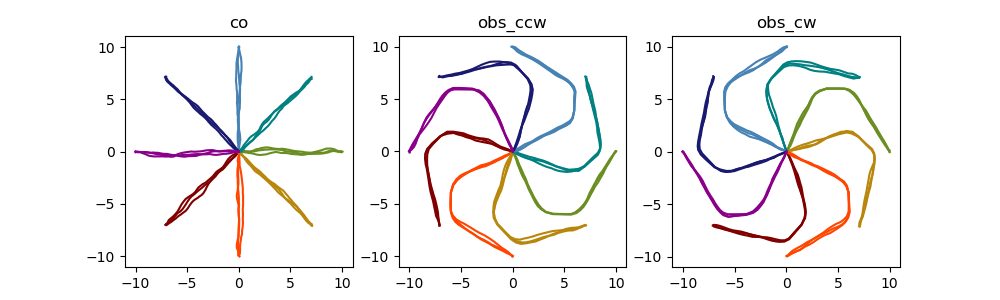

In [265]:
#Plot cw vs ccw trials, to confirm: 
m = 'n_null'
num_trials_plot = 3
save_bool = True
fig_name = m+'_' + str(num_trials_plot)+ 'ex_trials'

plot = {}
plot['size'] = (10,3)
plot['xlim'] = (-12.5,12.5)
plot['ylim'] = (-12.5,12.5)
task_rot_list = [0,1.1,1.2]
task_rot_label = ['co','obs_ccw', 'obs_cw']



plt.figure(figsize=plot['size'])
for i,task in enumerate(task_rot_list): 
    plt.subplot(1,3,i+1)
    plt.title(task_rot_label[i])    
    for target in range(num_targets):    
        sel = (df_lqr['task_rot']==task) & (df_lqr['bin']>=0) & (df_lqr['target']==target) & (df_lqr['model'] == m)
        df_sel = df_lqr[sel]
        #------------------------------------------------------------------------------------
        #TRIALS: 
        trial_start = np.where(df_sel['bin']==0)[0]
        trial_stop = np.where(df_sel['bin_end']==0)[0]
        trial_bound = np.vstack((trial_start,trial_stop)).T
        #------------------------------------------------------------------------------------
        for bnd in trial_bound[:num_trials_plot,:]: #trial_bound[0:1,:]:
#             if (task_str == 'co') or (task_str == 'obs') and (df_sel['obs_size'][bnd[0]:bnd[0]+1] == obs_big).bool(): 
            x = df_sel['kin_px'][bnd[0]:bnd[1]+1]
            y = df_sel['kin_py'][bnd[0]:bnd[1]+1]
            color = target_color[target]
            plt.plot(x,y,'-',color=color)
            
if save_bool:
    for ext in ext_list:
        plt.savefig(os.path.join(save_dir, fig_name+ext))            

In [ ]:
### Norm u

In [310]:
save_dir

'D:\\Dropbox\\BMI_co_obs_paper\\data\\vivek\\lqr'

<IPython.core.display.Javascript object>


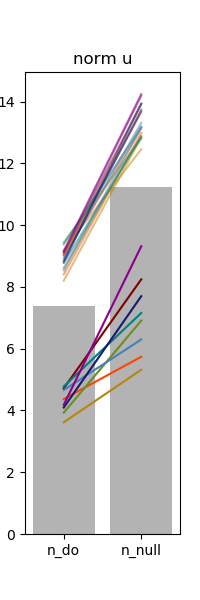

In [311]:
#Plot norm u for all movements: 

fig_name = 'norm_u'
save_bool = True

model_list = ['n_do', 'n_null']
task_alpha = {0:1, 1.1:0.5, 1.2:0.5}
plt.figure(figsize=(2,6))
u_m = {'n_do':[], 'n_null':[]}
for target in range(num_targets):
    for task in task_rot_list:
        
        x_plot = []
        y_plot = []
        for i,m in enumerate(model_list):
            x_plot.append(i)
            sel = \
            (df_norm_lqr['target']==target)\
            &(df_norm_lqr['task']==task)\
            &(df_norm_lqr['model']==m)
            y_i = float(df_norm_lqr.loc[sel,'norm_u'])
            y_plot.append(y_i)
            
            u_m[m].append(y_i)
            
        plt.plot(x_plot,y_plot,color=target_color[target], alpha=task_alpha[task]) #label='target'+str(target)+'task'+str(task)

plt.xticks(range(len(model_list)), model_list)
plt.ylabel('norm u')
plt.title('norm u')
plt.xlim([-0.5,1.5])

#plot the 
for m in model_list:
    u_m[m,'mean'] = np.mean(u_m[m])
plt_bar = [u_m['n_do', 'mean'], u_m['n_null', 'mean']]
plt.bar([0,1], plt_bar, width=0.8, color=0.7*np.ones(3))


if save_bool:
    for ext in ext_list:
        plt.savefig(os.path.join(save_dir, fig_name+ext))

In [308]:
len(u_m['n_do'])

24

In [309]:
#check p-value: 
scipy.stats.wilcoxon(u_m['n_do'], u_m['n_null'])

WilcoxonResult(statistic=0.0, pvalue=1.821529714896801e-05)

### Analyze diff command-movement vs command

In [11]:
n_list = ['n_'+str(i) for i in range(num_neurons)]

In [12]:
#mean diff: 
df_diff_col = n_list + ['diff', 'diff_null', 'diff_potent', 'ba', 'bm', 'model', 'target', 'task_rot', 'num']
nan_df = pd.DataFrame()
df_diff = []
for ba in range(num_angle_bins):
    sel_ba = (df_lqr['u_v_angle_bin']==ba)
    sel_d_ba = (df_mean['ba'] == ba)    
    for bm in range(num_mag_bins_analyze):
        sel_bm = (df_lqr['u_v_mag_bin']==bm)
        sel_d_bm = (df_mean['bm'] == bm)
        for m in model_list:
            sel_m = (df_lqr['model'] == m)
            sel_d_m = (df_mean['model'] == m)
            sel_d = sel_d_ba&sel_d_bm&sel_d_m
            mean_i = df_mean.loc[sel_d, n_list]
            
            
            for task in task_rot_list:
                sel_task = (df_lqr['task_rot']==task)
                for target in range(num_targets):
                    sel_target = (df_lqr['target']==target)
                    
                    sel = sel_ba&sel_bm&sel_m&sel_task&sel_target
                    num = len(np.where(sel)[0])
                    if num > 0:
                        n_i = df_lqr.loc[sel,n_list].mean()
                        diff_i = n_i-mean_i
                        diff_potent_i, diff_null_i, _ = bmi_util.proj_null_potent(Kn[2:4,:].T, np.array(diff_i).reshape((-1,1)))
                        
                        df_i = pd.DataFrame(pd.DataFrame(np.ones((1,len(df_diff_col)))*np.nan, columns=df_diff_col))
                        df_i.loc[0,n_list]=n_i
                        df_i['diff']=np.linalg.norm(diff_i)
                        df_i['diff_null']=np.linalg.norm(diff_null_i)
                        df_i['diff_potent']=np.linalg.norm(diff_potent_i)
                        df_i['ba'] = ba
                        df_i['bm'] = bm
                        df_i['model'] = m
                        df_i['task_rot'] = task
                        df_i['target'] = target
                        df_i['num'] = num

                        df_diff.append(df_i)
df_diff = pd.concat(df_diff, ignore_index=True)   

In [ ]:
# df_mean
# df_diff

<IPython.core.display.Javascript object>


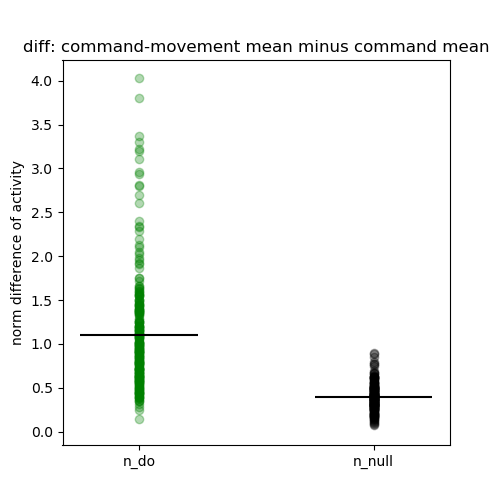

n_do
('n_do', 1.103857109212408)
n_null
('n_null', 0.39606464304724065)


Text(0,0.5,'norm difference of activity')

In [15]:
plt.figure(figsize=(5,5))

model_list = ['n_do', 'n_null']
model_color = {'n_do':'g', 'n_o':'r', 'n_null':'k'}
d_cm_diff = []

diff_sel = 'diff' #'diff', 'diff_potent'

min_obs = 1
for i,m in enumerate(model_list):
    print(m)
    sel_m = df_diff['model']==m
    sel_obs = df_diff['num']>=min_obs
    
    sel = sel_m&sel_obs
#     sel = sel_m&sel_obs
    diff_i = df_diff.loc[sel, diff_sel]
    d_cm_diff.append(diff_i)
    diff_mean_i = df_diff.loc[sel, diff_sel].mean()
    print(m, diff_mean_i)
#     num = df_diff.loc[sel, 'num'].mean()
#     print(m, test, num)
    plt.scatter(i*np.ones(len(diff_i)), diff_i, alpha=0.3,color=model_color[m])
    plt.hlines(diff_mean_i, i-0.25,i+0.25)
    
_=plt.xticks([0,1], model_list)
plt.title(diff_sel+':'+' command-movement mean minus command mean')
plt.ylabel('norm difference of activity')
    

<IPython.core.display.Javascript object>


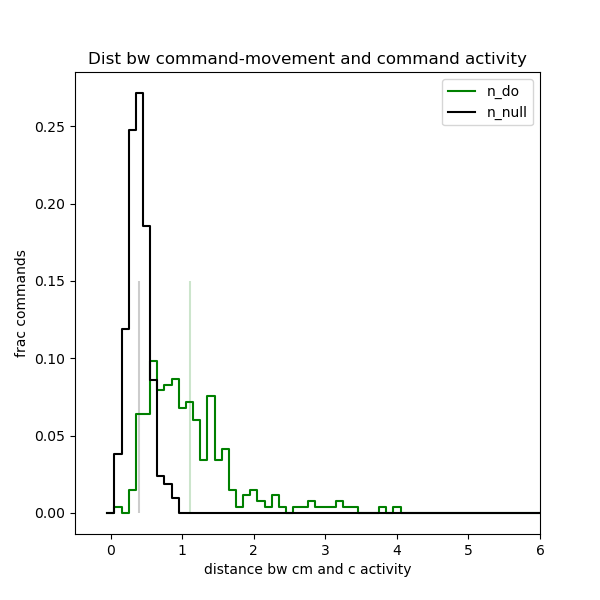

111
(224L,)
111
(224L,)


Text(0.5,1,'Dist bw command-movement and command activity')

In [16]:
#Histogram the diffs and plot overlapping distributions:
vmin = 0
vmax = 11
num_bins = (vmax-vmin)*10+1
cm_diff_bins_c = np.linspace(vmin,vmax,num_bins)
bin_w = cm_diff_bins_c[1]-cm_diff_bins_c[0]
cm_diff_bins_e = np.vstack((cm_diff_bins_c-bin_w/2, cm_diff_bins_c+bin_w/2))
bin_dic = {0:cm_diff_bins_e}

cm_diff_binned = []
for i,d in enumerate(d_cm_diff):
    d = np.array(d).reshape((-1,1))
    bin_result, hist_result = bmi_b.bin_vec_data(d,bin_dic)
    cm_diff_binned.append(hist_result)


model_color = {'n_do':'g', 'n_o':'r', 'n_null':'k'}    
cm_diff_bins_e_flat = np.hstack((cm_diff_bins_e[0,:], cm_diff_bins_e[1,-1]))

plt.figure(figsize=(6,6))
for i,d in enumerate(cm_diff_binned):
    m = model_list[i]
    d_plot = d/np.sum(d)
#     d_plot = np.cumsum(d_plot)
    bmi_util.hist_step_plot(cm_diff_bins_e_flat, d_plot,color=model_color[m],label=m)
    
    d_mean = np.mean(d_cm_diff[i])
    plt.vlines(d_mean, 0, 0.15, color=model_color[m],alpha=0.2)
plt.xlim((-0.5,6))    
plt.legend()    
plt.xlabel('distance bw cm and c activity')
plt.ylabel('frac commands')
plt.title('Dist bw command-movement and command activity')


In [13]:
#Let's loop and confirm there's no within bin difference: 
#loop each command (get command distribution)
#loop each movement (get cm distribution)
#use t-test to compare x and y distribution

model_list = ['n_do', 'n_null']
df_t_col = ['diff_x', 'diff_y', 'xstat', 'xp', 'ystat', 'yp', 'ba', 'bm', 'model', 'task_rot', 'target', 'num_cm', 'num_c']
df_t = []
for ba in range(num_angle_bins):
    sel_ba = (df_lqr['u_v_angle_bin']==ba)
    for bm in range(num_mag_bins_analyze):
        sel_bm = (df_lqr['u_v_mag_bin']==bm)
        for m in model_list:
            sel_m = (df_lqr['model'] == m)
            sel_c = sel_ba&sel_bm&sel_m
            cx = df_lqr.loc[sel_c, 'u_vx'] 
            cy = df_lqr.loc[sel_c, 'u_vy'] 
            num_c = len(np.where(sel_c)[0])
            
            for task in task_rot_list:
                sel_task = (df_lqr['task_rot']==task)
                for target in range(num_targets):
                    sel_target = (df_lqr['target']==target)
                    sel_cm = sel_ba&sel_bm&sel_m&sel_task&sel_target
                    cmx = df_lqr.loc[sel_cm, 'u_vx'] 
                    cmy = df_lqr.loc[sel_cm, 'u_vy']                     
                    
                    num_cm = len(np.where(sel_cm)[0])
                    if num_cm > 0:
                        print(ba, bm, m, task, target)
                        xstat, xp = sio_stat.ttest_ind(cx, cmx)
                        ystat, yp = sio_stat.ttest_ind(cy, cmy)
                        
                        df_i = pd.DataFrame(pd.DataFrame(np.ones((1,len(df_t_col)))*np.nan, columns=df_t_col))
                        df_i['diff_x']=cx.mean()-cmx.mean()
                        df_i['diff_y']=cy.mean()-cmy.mean()
                        df_i['xstat'] = xstat
                        df_i['xp'] = xp
                        df_i['ystat'] = ystat
                        df_i['yp'] = yp
                        
                        df_i['ba'] = ba
                        df_i['bm'] = bm
                        df_i['model'] = m
                        df_i['task_rot'] = task
                        df_i['target'] = target
                        df_i['num_cm'] = num_cm
                        df_i['num_c'] = num_c

                        df_t.append(df_i)
df_t = pd.concat(df_t, ignore_index=True)              

(0, 0, 'n_do', 0, 0)
(0, 0, 'n_do', 0, 1)
(0, 0, 'n_do', 0, 2)
(0, 0, 'n_do', 0, 3)
(0, 0, 'n_do', 0, 4)
(0, 0, 'n_do', 0, 5)
(0, 0, 'n_do', 0, 6)
(0, 0, 'n_do', 0, 7)
(0, 0, 'n_do', 1.1, 0)
(0, 0, 'n_do', 1.1, 1)
(0, 0, 'n_do', 1.1, 2)
(0, 0, 'n_do', 1.1, 3)
(0, 0, 'n_do', 1.1, 4)
(0, 0, 'n_do', 1.1, 5)
(0, 0, 'n_do', 1.1, 6)
(0, 0, 'n_do', 1.1, 7)
(0, 0, 'n_do', 1.2, 0)
(0, 0, 'n_do', 1.2, 1)
(0, 0, 'n_do', 1.2, 2)
(0, 0, 'n_do', 1.2, 3)
(0, 0, 'n_do', 1.2, 4)
(0, 0, 'n_do', 1.2, 5)
(0, 0, 'n_do', 1.2, 6)
(0, 0, 'n_do', 1.2, 7)
(0, 0, 'n_null', 0, 0)
(0, 0, 'n_null', 0, 1)
(0, 0, 'n_null', 0, 2)
(0, 0, 'n_null', 0, 3)
(0, 0, 'n_null', 0, 4)
(0, 0, 'n_null', 0, 5)
(0, 0, 'n_null', 0, 6)
(0, 0, 'n_null', 0, 7)
(0, 0, 'n_null', 1.1, 0)
(0, 0, 'n_null', 1.1, 1)
(0, 0, 'n_null', 1.1, 2)
(0, 0, 'n_null', 1.1, 3)
(0, 0, 'n_null', 1.1, 4)
(0, 0, 'n_null', 1.1, 5)
(0, 0, 'n_null', 1.1, 6)
(0, 0, 'n_null', 1.1, 7)
(0, 0, 'n_null', 1.2, 0)
(0, 0, 'n_null', 1.2, 1)
(0, 0, 'n_null', 1.2, 2)
(0, 0

(1, 3, 'n_do', 1.2, 5)
(1, 3, 'n_do', 1.2, 6)
(1, 3, 'n_do', 1.2, 7)
(1, 3, 'n_null', 0, 0)
(1, 3, 'n_null', 0, 1)
(1, 3, 'n_null', 0, 2)
(1, 3, 'n_null', 0, 3)
(1, 3, 'n_null', 0, 4)
(1, 3, 'n_null', 0, 5)
(1, 3, 'n_null', 0, 6)
(1, 3, 'n_null', 0, 7)
(1, 3, 'n_null', 1.1, 0)
(1, 3, 'n_null', 1.1, 1)
(1, 3, 'n_null', 1.1, 2)
(1, 3, 'n_null', 1.1, 3)
(1, 3, 'n_null', 1.1, 4)
(1, 3, 'n_null', 1.1, 5)
(1, 3, 'n_null', 1.1, 6)
(1, 3, 'n_null', 1.1, 7)
(1, 3, 'n_null', 1.2, 0)
(1, 3, 'n_null', 1.2, 1)
(1, 3, 'n_null', 1.2, 2)
(1, 3, 'n_null', 1.2, 3)
(1, 3, 'n_null', 1.2, 4)
(1, 3, 'n_null', 1.2, 5)
(1, 3, 'n_null', 1.2, 6)
(1, 3, 'n_null', 1.2, 7)
(2, 0, 'n_do', 0, 0)
(2, 0, 'n_do', 0, 1)
(2, 0, 'n_do', 0, 2)
(2, 0, 'n_do', 0, 3)
(2, 0, 'n_do', 0, 4)
(2, 0, 'n_do', 0, 5)
(2, 0, 'n_do', 0, 6)
(2, 0, 'n_do', 0, 7)
(2, 0, 'n_do', 1.1, 0)
(2, 0, 'n_do', 1.1, 1)
(2, 0, 'n_do', 1.1, 2)
(2, 0, 'n_do', 1.1, 3)
(2, 0, 'n_do', 1.1, 4)
(2, 0, 'n_do', 1.1, 5)
(2, 0, 'n_do', 1.1, 6)
(2, 0, 'n_do', 1.1

(3, 2, 'n_null', 1.1, 4)
(3, 2, 'n_null', 1.1, 5)
(3, 2, 'n_null', 1.1, 6)
(3, 2, 'n_null', 1.1, 7)
(3, 2, 'n_null', 1.2, 0)
(3, 2, 'n_null', 1.2, 1)
(3, 2, 'n_null', 1.2, 2)
(3, 2, 'n_null', 1.2, 3)
(3, 2, 'n_null', 1.2, 4)
(3, 2, 'n_null', 1.2, 5)
(3, 2, 'n_null', 1.2, 6)
(3, 2, 'n_null', 1.2, 7)
(3, 3, 'n_do', 0, 0)
(3, 3, 'n_do', 0, 1)
(3, 3, 'n_do', 0, 2)
(3, 3, 'n_do', 0, 3)
(3, 3, 'n_do', 0, 4)
(3, 3, 'n_do', 0, 5)
(3, 3, 'n_do', 0, 6)
(3, 3, 'n_do', 0, 7)
(3, 3, 'n_do', 1.1, 0)
(3, 3, 'n_do', 1.1, 1)
(3, 3, 'n_do', 1.1, 2)
(3, 3, 'n_do', 1.1, 3)
(3, 3, 'n_do', 1.1, 4)
(3, 3, 'n_do', 1.1, 5)
(3, 3, 'n_do', 1.1, 6)
(3, 3, 'n_do', 1.1, 7)
(3, 3, 'n_do', 1.2, 0)
(3, 3, 'n_do', 1.2, 1)
(3, 3, 'n_do', 1.2, 2)
(3, 3, 'n_do', 1.2, 3)
(3, 3, 'n_do', 1.2, 4)
(3, 3, 'n_do', 1.2, 5)
(3, 3, 'n_do', 1.2, 6)
(3, 3, 'n_do', 1.2, 7)
(3, 3, 'n_null', 0, 0)
(3, 3, 'n_null', 0, 1)
(3, 3, 'n_null', 0, 2)
(3, 3, 'n_null', 0, 3)
(3, 3, 'n_null', 0, 4)
(3, 3, 'n_null', 0, 5)
(3, 3, 'n_null', 0, 6)
(3,

(5, 2, 'n_do', 0, 4)
(5, 2, 'n_do', 0, 5)
(5, 2, 'n_do', 0, 6)
(5, 2, 'n_do', 0, 7)
(5, 2, 'n_do', 1.1, 0)
(5, 2, 'n_do', 1.1, 1)
(5, 2, 'n_do', 1.1, 2)
(5, 2, 'n_do', 1.1, 3)
(5, 2, 'n_do', 1.1, 4)
(5, 2, 'n_do', 1.1, 5)
(5, 2, 'n_do', 1.1, 6)
(5, 2, 'n_do', 1.1, 7)
(5, 2, 'n_do', 1.2, 0)
(5, 2, 'n_do', 1.2, 1)
(5, 2, 'n_do', 1.2, 2)
(5, 2, 'n_do', 1.2, 3)
(5, 2, 'n_do', 1.2, 4)
(5, 2, 'n_do', 1.2, 5)
(5, 2, 'n_do', 1.2, 6)
(5, 2, 'n_do', 1.2, 7)
(5, 2, 'n_null', 0, 0)
(5, 2, 'n_null', 0, 1)
(5, 2, 'n_null', 0, 2)
(5, 2, 'n_null', 0, 3)
(5, 2, 'n_null', 0, 4)
(5, 2, 'n_null', 0, 5)
(5, 2, 'n_null', 0, 6)
(5, 2, 'n_null', 0, 7)
(5, 2, 'n_null', 1.1, 0)
(5, 2, 'n_null', 1.1, 1)
(5, 2, 'n_null', 1.1, 2)
(5, 2, 'n_null', 1.1, 3)
(5, 2, 'n_null', 1.1, 4)
(5, 2, 'n_null', 1.1, 5)
(5, 2, 'n_null', 1.1, 6)
(5, 2, 'n_null', 1.1, 7)
(5, 2, 'n_null', 1.2, 0)
(5, 2, 'n_null', 1.2, 1)
(5, 2, 'n_null', 1.2, 2)
(5, 2, 'n_null', 1.2, 3)
(5, 2, 'n_null', 1.2, 4)
(5, 2, 'n_null', 1.2, 5)
(5, 2, 'n_null

(7, 1, 'n_do', 1.2, 7)
(7, 1, 'n_null', 0, 0)
(7, 1, 'n_null', 0, 1)
(7, 1, 'n_null', 0, 2)
(7, 1, 'n_null', 0, 3)
(7, 1, 'n_null', 0, 4)
(7, 1, 'n_null', 0, 5)
(7, 1, 'n_null', 0, 6)
(7, 1, 'n_null', 0, 7)
(7, 1, 'n_null', 1.1, 0)
(7, 1, 'n_null', 1.1, 1)
(7, 1, 'n_null', 1.1, 2)
(7, 1, 'n_null', 1.1, 3)
(7, 1, 'n_null', 1.1, 4)
(7, 1, 'n_null', 1.1, 5)
(7, 1, 'n_null', 1.1, 6)
(7, 1, 'n_null', 1.1, 7)
(7, 1, 'n_null', 1.2, 0)
(7, 1, 'n_null', 1.2, 1)
(7, 1, 'n_null', 1.2, 2)
(7, 1, 'n_null', 1.2, 3)
(7, 1, 'n_null', 1.2, 4)
(7, 1, 'n_null', 1.2, 5)
(7, 1, 'n_null', 1.2, 6)
(7, 1, 'n_null', 1.2, 7)
(7, 2, 'n_do', 0, 0)
(7, 2, 'n_do', 0, 1)
(7, 2, 'n_do', 0, 2)
(7, 2, 'n_do', 0, 3)
(7, 2, 'n_do', 0, 4)
(7, 2, 'n_do', 0, 5)
(7, 2, 'n_do', 0, 6)
(7, 2, 'n_do', 0, 7)
(7, 2, 'n_do', 1.1, 0)
(7, 2, 'n_do', 1.1, 1)
(7, 2, 'n_do', 1.1, 2)
(7, 2, 'n_do', 1.1, 3)
(7, 2, 'n_do', 1.1, 4)
(7, 2, 'n_do', 1.1, 5)
(7, 2, 'n_do', 1.1, 6)
(7, 2, 'n_do', 1.1, 7)
(7, 2, 'n_do', 1.2, 0)
(7, 2, 'n_do', 1.2

In [14]:
df_t

diff_x    diff_y      xstat            xp      ystat            yp  \
0     0.032248  0.021425   6.053266  1.438678e-09   4.061893  4.881812e-05   
1    -0.002747  0.020075  -0.507554  6.117705e-01   3.729494  1.922707e-04   
2    -0.048483 -0.006376  -6.983613  2.948343e-12  -0.920642  3.572461e-01   
3    -0.061790 -0.032771  -7.409347  1.309833e-13  -3.949477  7.853891e-05   
4    -0.070901 -0.051215  -8.308000  1.022659e-16  -6.037648  1.586067e-09   
5    -0.040007 -0.064632  -4.990221  6.071748e-07  -8.156547  3.608937e-16   
6     0.009808 -0.038792   1.312857  1.892430e-01  -5.255415  1.489028e-07   
7     0.038442 -0.006556   6.054784  1.425740e-09  -1.042895  2.970070e-01   
8     0.007296  0.017818   0.888560  3.742480e-01   2.189627  2.856059e-02   
9     0.034165  0.022114   4.033750  5.505857e-05   2.636546  8.380722e-03   
10    0.013581  0.031355   1.729476  8.373629e-02   4.027026  5.665424e-05   
11   -0.045648 -0.006628  -4.994146  5.950091e-07  -0.729325  4.658097e-01   
12   -0.015810 -0.019896  -1.409104  1.588172e-01  -1.788003  7.378788e-02   
13   -0.016995 -0.031605  -1.576242  1.149830e-01  -2.959995  3.079404e-03   
14    0.024228 -0.009780   2.611232  9.027142e-03  -1.064365  2.871740e-01   
15    0.019792  0.027328   2.570423  1.016318e-02   3.573603  3.527673e-04   
16    0.009319  0.008695   1.057735  2.901867e-01   0.994740  3.198727e-01   
17    0.028128  0.024164   3.369775  7.534453e-04   2.916554  3.542396e-03   
18    0.000497  0.023407   0.062164  9.504329e-01   2.951429  3.166032e-03   
19   -0.041148 -0.005031  -4.336993  1.450208e-05  -0.533049  5.940042e-01   
20   -0.032885 -0.043828  -2.770108  5.608025e-03  -3.724433  1.961973e-04   
21   -0.014815 -0.033813  -1.351897  1.764209e-01  -3.112833  1.855153e-03   
22    0.047173  0.004294   5.434849  5.536189e-08   0.500696  6.165895e-01   
23    0.017294  0.031321   2.184552  2.893104e-02   3.980631  6.892776e-05   
24    0.040128  0.026389   8.563068  1.153041e-17   5.626560  1.855493e-08   
25   -0.016702  0.026836  -3.413369  6.425455e-04   5.445430  5.210816e-08   
26   -0.074424 -0.013971 -10.714909  9.807025e-27  -2.002150  4.527856e-02   
27   -0.070635 -0.040558  -8.137139  4.223130e-16  -4.661818  3.149547e-06   
28   -0.089346 -0.078036 -10.596935  3.473367e-26  -9.244245  2.541391e-20   
29   -0.039788 -0.071747  -4.954885  7.281617e-07  -8.950108  3.776888e-19   
...        ...       ...        ...           ...        ...           ...   
1506 -0.087659  0.391598  -3.492759  4.786777e-04   9.088419  1.058945e-19   
1507 -0.094790  0.072945  -2.151841  3.141713e-02   0.964534  3.347851e-01   
1508 -0.102918 -0.440146  -4.558845  5.161815e-06 -11.359660  7.534975e-30   
1509  0.005733 -0.252277   0.618551  5.362163e-01 -15.929170  6.285373e-57   
1510  0.041610  0.072661   5.019373  5.208806e-07   5.122679  3.027816e-07   
1511  0.119497 -0.047182  12.183848  4.442653e-34  -2.810098  4.955389e-03   
1512 -0.121572  0.322264  -8.096125  5.910986e-16  11.810414  4.138100e-32   
1513 -0.117904  0.353605  -2.767772  5.648027e-03   4.567538  4.957207e-06   
1514 -0.019169  0.078954  -0.323756  7.461251e-01   0.733934  4.629956e-01   
1515 -0.035200  0.344614  -0.581204  5.611079e-01   3.131981  1.738212e-03   
1516  0.031643  0.090293   0.579976  5.619356e-01   0.910915  3.623485e-01   
1517 -0.099366 -0.194956  -2.423918  1.536075e-02  -2.617122  8.872520e-03   
1518 -0.132599 -0.206414 -10.077901  7.619426e-24  -8.603942  8.110614e-18   
1519 -0.094875  0.059685 -11.012469  3.792076e-28   3.790320  1.507629e-04   
1520  0.044152 -0.141666   5.659169  1.535344e-08 -10.039370  1.118123e-23   
1521 -0.042731  0.317318  -4.376316  1.211381e-05  17.913034  2.335926e-71   
1522 -0.074614  0.288069  -2.187657  2.870331e-02   4.649172  3.348824e-06   
1523  0.035275  0.020923   0.658508  5.102177e-01   0.214940  8.298155e-01   
1524 -0.088136 -0.283759  -2.784858  5.358929e-03  -4.934557  8.082138e-07   
1525  0.008128 -0.334617   0.8

### Check the distribution of commands for each type of movement

In [17]:
#Useful especially when splitting an obstacle movement into cw vs ccw.
move_list = []
for target in range(num_targets):
    for task in task_rot_list:
        move_list.append((target,task))
m_list = move_list #In case we prefer 
num_move = len(m_list)        
#List of commands in case it's useful    
c_list = [] #(bm,ba)
for bm in range(num_mag_bins_analyze):
    for ba in range(num_angle_bins):
        c_list.append((bm,ba))        
num_c = len(c_list)
#List of neurons:
n_list = ['n_'+str(i) for i in range(num_neurons)]

In [18]:
#Count the number of observations for each command for each movement:
t_start = timeit.default_timer()
cd = {} #command data
model_cm_dist = {}
model_list = ['n_do', 'n_null']
for model in model_list:
    sel_model = (df_lqr.loc[:,'model']==model)
    model_cm_dist[model] = xr.DataArray(np.zeros((num_move, num_c)),
                                       coords={'m':range(num_move),'c':range(num_c)},
                                       dims=['m','c'])
    for ic, c in enumerate(c_list):
        bm = c[0]
        ba = c[1]
        sel_c = (df_lqr.loc[:,'u_v_mag_bin']==bm)&(df_lqr.loc[:,'u_v_angle_bin']==ba)
        
        
        for im, m in enumerate(m_list):
            print(model, c, m)
            target = m[0]
            task = m[1]
            sel_m = (df_lqr.loc[:,'target']==target)&(df_lqr.loc[:,'task_rot']==task)
            
            sel = sel_model&sel_c&sel_m
            num_obs = sum(sel)
            model_cm_dist[model].loc[im, ic] = num_obs
t_elapsed = timeit.default_timer()-t_start
print(t_elapsed)

('n_do', (0, 0), (0, 0))
('n_do', (0, 0), (0, 1.1))
('n_do', (0, 0), (0, 1.2))
('n_do', (0, 0), (1, 0))
('n_do', (0, 0), (1, 1.1))
('n_do', (0, 0), (1, 1.2))
('n_do', (0, 0), (2, 0))
('n_do', (0, 0), (2, 1.1))
('n_do', (0, 0), (2, 1.2))
('n_do', (0, 0), (3, 0))
('n_do', (0, 0), (3, 1.1))
('n_do', (0, 0), (3, 1.2))
('n_do', (0, 0), (4, 0))
('n_do', (0, 0), (4, 1.1))
('n_do', (0, 0), (4, 1.2))
('n_do', (0, 0), (5, 0))
('n_do', (0, 0), (5, 1.1))
('n_do', (0, 0), (5, 1.2))
('n_do', (0, 0), (6, 0))
('n_do', (0, 0), (6, 1.1))
('n_do', (0, 0), (6, 1.2))
('n_do', (0, 0), (7, 0))
('n_do', (0, 0), (7, 1.1))
('n_do', (0, 0), (7, 1.2))
('n_do', (0, 1), (0, 0))
('n_do', (0, 1), (0, 1.1))
('n_do', (0, 1), (0, 1.2))
('n_do', (0, 1), (1, 0))
('n_do', (0, 1), (1, 1.1))
('n_do', (0, 1), (1, 1.2))
('n_do', (0, 1), (2, 0))
('n_do', (0, 1), (2, 1.1))
('n_do', (0, 1), (2, 1.2))
('n_do', (0, 1), (3, 0))
('n_do', (0, 1), (3, 1.1))
('n_do', (0, 1), (3, 1.2))
('n_do', (0, 1), (4, 0))
('n_do', (0, 1), (4, 1.1))


('n_do', (1, 5), (5, 1.1))
('n_do', (1, 5), (5, 1.2))
('n_do', (1, 5), (6, 0))
('n_do', (1, 5), (6, 1.1))
('n_do', (1, 5), (6, 1.2))
('n_do', (1, 5), (7, 0))
('n_do', (1, 5), (7, 1.1))
('n_do', (1, 5), (7, 1.2))
('n_do', (1, 6), (0, 0))
('n_do', (1, 6), (0, 1.1))
('n_do', (1, 6), (0, 1.2))
('n_do', (1, 6), (1, 0))
('n_do', (1, 6), (1, 1.1))
('n_do', (1, 6), (1, 1.2))
('n_do', (1, 6), (2, 0))
('n_do', (1, 6), (2, 1.1))
('n_do', (1, 6), (2, 1.2))
('n_do', (1, 6), (3, 0))
('n_do', (1, 6), (3, 1.1))
('n_do', (1, 6), (3, 1.2))
('n_do', (1, 6), (4, 0))
('n_do', (1, 6), (4, 1.1))
('n_do', (1, 6), (4, 1.2))
('n_do', (1, 6), (5, 0))
('n_do', (1, 6), (5, 1.1))
('n_do', (1, 6), (5, 1.2))
('n_do', (1, 6), (6, 0))
('n_do', (1, 6), (6, 1.1))
('n_do', (1, 6), (6, 1.2))
('n_do', (1, 6), (7, 0))
('n_do', (1, 6), (7, 1.1))
('n_do', (1, 6), (7, 1.2))
('n_do', (1, 7), (0, 0))
('n_do', (1, 7), (0, 1.1))
('n_do', (1, 7), (0, 1.2))
('n_do', (1, 7), (1, 0))
('n_do', (1, 7), (1, 1.1))
('n_do', (1, 7), (1, 1.2)

('n_do', (3, 3), (1, 0))
('n_do', (3, 3), (1, 1.1))
('n_do', (3, 3), (1, 1.2))
('n_do', (3, 3), (2, 0))
('n_do', (3, 3), (2, 1.1))
('n_do', (3, 3), (2, 1.2))
('n_do', (3, 3), (3, 0))
('n_do', (3, 3), (3, 1.1))
('n_do', (3, 3), (3, 1.2))
('n_do', (3, 3), (4, 0))
('n_do', (3, 3), (4, 1.1))
('n_do', (3, 3), (4, 1.2))
('n_do', (3, 3), (5, 0))
('n_do', (3, 3), (5, 1.1))
('n_do', (3, 3), (5, 1.2))
('n_do', (3, 3), (6, 0))
('n_do', (3, 3), (6, 1.1))
('n_do', (3, 3), (6, 1.2))
('n_do', (3, 3), (7, 0))
('n_do', (3, 3), (7, 1.1))
('n_do', (3, 3), (7, 1.2))
('n_do', (3, 4), (0, 0))
('n_do', (3, 4), (0, 1.1))
('n_do', (3, 4), (0, 1.2))
('n_do', (3, 4), (1, 0))
('n_do', (3, 4), (1, 1.1))
('n_do', (3, 4), (1, 1.2))
('n_do', (3, 4), (2, 0))
('n_do', (3, 4), (2, 1.1))
('n_do', (3, 4), (2, 1.2))
('n_do', (3, 4), (3, 0))
('n_do', (3, 4), (3, 1.1))
('n_do', (3, 4), (3, 1.2))
('n_do', (3, 4), (4, 0))
('n_do', (3, 4), (4, 1.1))
('n_do', (3, 4), (4, 1.2))
('n_do', (3, 4), (5, 0))
('n_do', (3, 4), (5, 1.1))


('n_null', (0, 7), (5, 1.2))
('n_null', (0, 7), (6, 0))
('n_null', (0, 7), (6, 1.1))
('n_null', (0, 7), (6, 1.2))
('n_null', (0, 7), (7, 0))
('n_null', (0, 7), (7, 1.1))
('n_null', (0, 7), (7, 1.2))
('n_null', (1, 0), (0, 0))
('n_null', (1, 0), (0, 1.1))
('n_null', (1, 0), (0, 1.2))
('n_null', (1, 0), (1, 0))
('n_null', (1, 0), (1, 1.1))
('n_null', (1, 0), (1, 1.2))
('n_null', (1, 0), (2, 0))
('n_null', (1, 0), (2, 1.1))
('n_null', (1, 0), (2, 1.2))
('n_null', (1, 0), (3, 0))
('n_null', (1, 0), (3, 1.1))
('n_null', (1, 0), (3, 1.2))
('n_null', (1, 0), (4, 0))
('n_null', (1, 0), (4, 1.1))
('n_null', (1, 0), (4, 1.2))
('n_null', (1, 0), (5, 0))
('n_null', (1, 0), (5, 1.1))
('n_null', (1, 0), (5, 1.2))
('n_null', (1, 0), (6, 0))
('n_null', (1, 0), (6, 1.1))
('n_null', (1, 0), (6, 1.2))
('n_null', (1, 0), (7, 0))
('n_null', (1, 0), (7, 1.1))
('n_null', (1, 0), (7, 1.2))
('n_null', (1, 1), (0, 0))
('n_null', (1, 1), (0, 1.1))
('n_null', (1, 1), (0, 1.2))
('n_null', (1, 1), (1, 0))
('n_null'

('n_null', (2, 4), (3, 0))
('n_null', (2, 4), (3, 1.1))
('n_null', (2, 4), (3, 1.2))
('n_null', (2, 4), (4, 0))
('n_null', (2, 4), (4, 1.1))
('n_null', (2, 4), (4, 1.2))
('n_null', (2, 4), (5, 0))
('n_null', (2, 4), (5, 1.1))
('n_null', (2, 4), (5, 1.2))
('n_null', (2, 4), (6, 0))
('n_null', (2, 4), (6, 1.1))
('n_null', (2, 4), (6, 1.2))
('n_null', (2, 4), (7, 0))
('n_null', (2, 4), (7, 1.1))
('n_null', (2, 4), (7, 1.2))
('n_null', (2, 5), (0, 0))
('n_null', (2, 5), (0, 1.1))
('n_null', (2, 5), (0, 1.2))
('n_null', (2, 5), (1, 0))
('n_null', (2, 5), (1, 1.1))
('n_null', (2, 5), (1, 1.2))
('n_null', (2, 5), (2, 0))
('n_null', (2, 5), (2, 1.1))
('n_null', (2, 5), (2, 1.2))
('n_null', (2, 5), (3, 0))
('n_null', (2, 5), (3, 1.1))
('n_null', (2, 5), (3, 1.2))
('n_null', (2, 5), (4, 0))
('n_null', (2, 5), (4, 1.1))
('n_null', (2, 5), (4, 1.2))
('n_null', (2, 5), (5, 0))
('n_null', (2, 5), (5, 1.1))
('n_null', (2, 5), (5, 1.2))
('n_null', (2, 5), (6, 0))
('n_null', (2, 5), (6, 1.1))
('n_null'

<IPython.core.display.Javascript object>


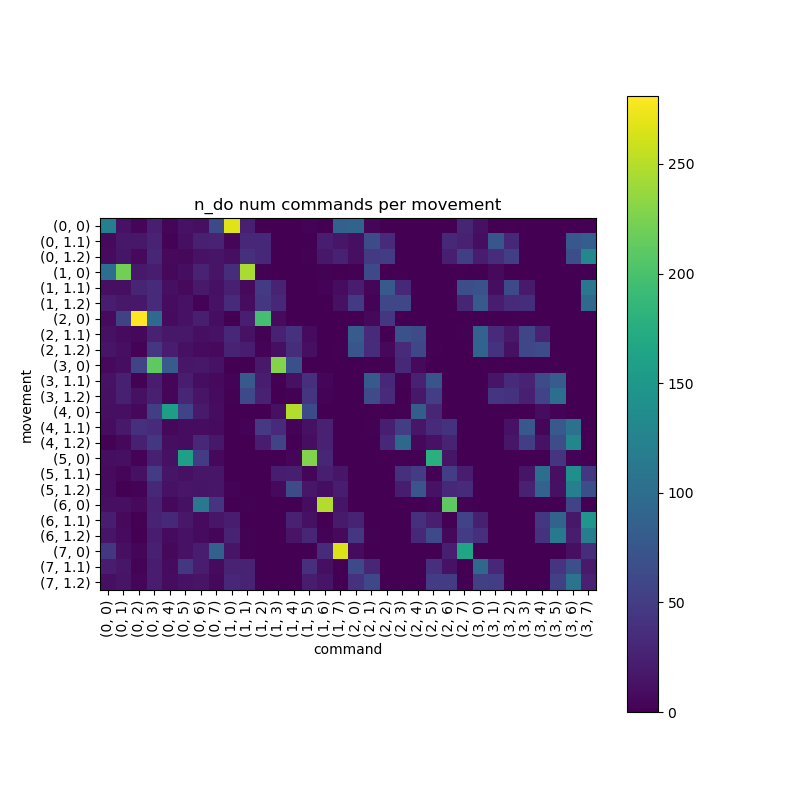

<IPython.core.display.Javascript object>


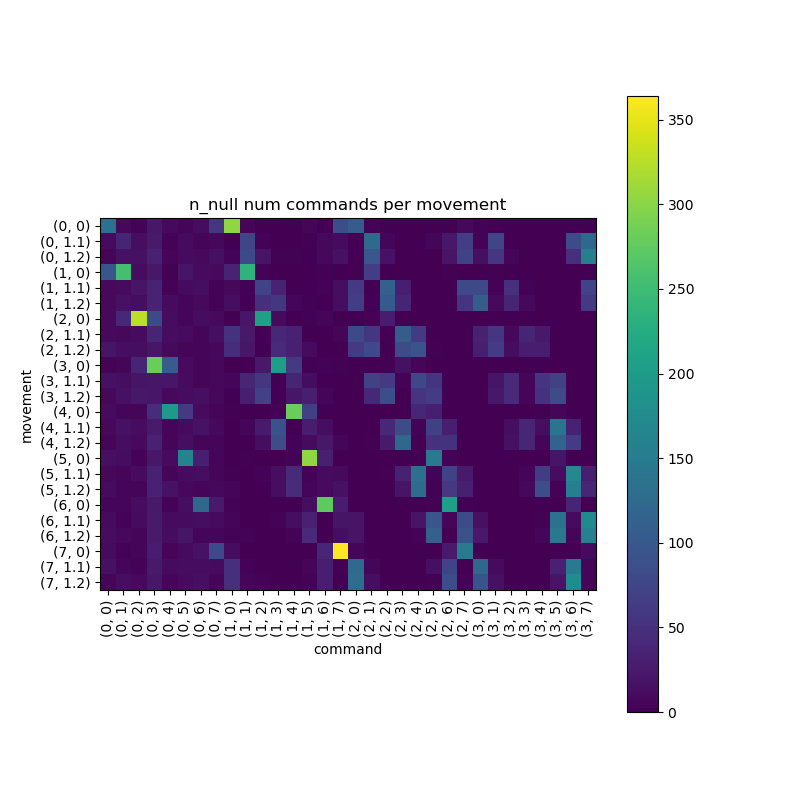

<IPython.core.display.Javascript object>


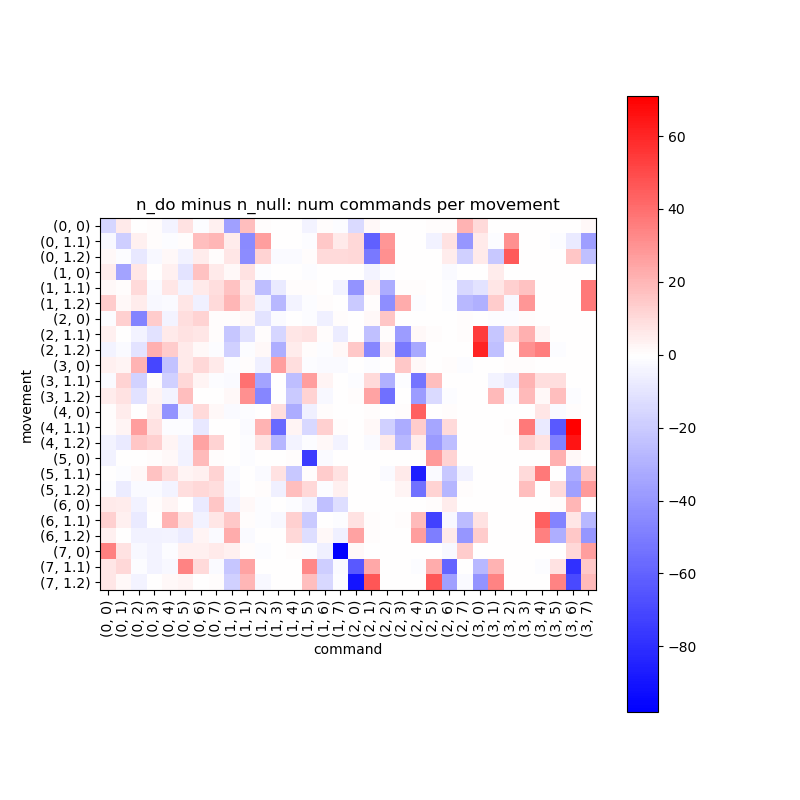

In [19]:
# plt.figure(figsize=(16,8))
for i,model in enumerate(model_list):
#     plt.subplot(2,1,i+1)
    plt.figure(figsize=(8,8))
    plt.imshow(model_cm_dist[model], cmap='viridis')
    plt.xticks(range(num_c),c_list,rotation=90)
    plt.yticks(range(num_move),m_list,rotation=0)
    plt.xlabel('command')
    plt.ylabel('movement')
    
    plt.title(model + ' num commands per movement')
    plt.colorbar()

#DIFF: 
dist_diff = model_cm_dist['n_do'] - model_cm_dist['n_null']
v_mid = 0
v_min = dist_diff.min()
v_max = dist_diff.max()
plt.figure(figsize=(8,8))
plt.imshow(dist_diff, cmap='bwr', norm=MidpointNormalize(midpoint=v_mid,vmin=v_min, vmax=v_max))    
plt.xticks(range(num_c),c_list,rotation=90)
plt.yticks(range(num_move),m_list,rotation=0)
plt.xlabel('command')
plt.ylabel('movement')

plt.title('n_do minus n_null:' + ' num commands per movement')
plt.colorbar()

### Match command distribution

In [ ]:
# bmi_b.subsample_dataset_to_match_mean_target_dataset()
# INPUT: 
# match_var, d_ss, d_target, p_sig=0.05, frac_data_exclude_per_iter=0.05, min_frac_remain=0.1
# OUTPUT:  
#success, kept_list, discard_list, df_match, ttest_r, mean_r

In [28]:
list(df_lqr.columns)

['n_0',
 'n_1',
 'n_2',
 'n_3',
 'n_4',
 'n_5',
 'n_6',
 'n_7',
 'n_8',
 'n_9',
 'n_10',
 'n_11',
 'n_12',
 'n_13',
 'n_14',
 'n_15',
 'n_16',
 'n_17',
 'n_18',
 'n_19',
 'n_20',
 'n_21',
 'n_22',
 'n_23',
 'n_24',
 'n_25',
 'n_26',
 'n_27',
 'n_28',
 'n_29',
 'n_30',
 'n_31',
 'n_32',
 'n_33',
 'n_34',
 'n_35',
 'n_36',
 'n_37',
 'n_38',
 'n_39',
 'n_40',
 'n_41',
 'n_42',
 'n_43',
 'kin_px',
 'kin_py',
 'kin_vx',
 'kin_vy',
 'u_px',
 'u_py',
 'u_vx',
 'u_vy',
 'u_offset',
 'u_0',
 'u_1',
 'u_2',
 'u_3',
 'u_4',
 'u_5',
 'u_6',
 'u_7',
 'u_8',
 'u_9',
 'u_10',
 'u_11',
 'u_12',
 'u_13',
 'u_14',
 'u_15',
 'u_16',
 'u_17',
 'u_18',
 'u_19',
 'u_20',
 'u_21',
 'u_22',
 'u_23',
 'u_24',
 'u_25',
 'u_26',
 'u_27',
 'u_28',
 'u_29',
 'u_30',
 'u_31',
 'u_32',
 'u_33',
 'u_34',
 'u_35',
 'u_36',
 'u_37',
 'u_38',
 'u_39',
 'u_40',
 'u_41',
 'u_42',
 'u_43',
 'task_rot',
 'target',
 'bin',
 'bin_end',
 'trial',
 'model',
 'p_mag',
 'p_angle',
 'v_mag',
 'v_angle',
 'u_p_mag',
 'u_p_angle',
 

In [ ]:
#xarray dims: ['v', 'observation']
#can you assign df to DataArray directly? 

#bmi_b.df_idx2da(df, idx, var)
#             index_i = list(df_lqr.loc[].index.values) 
#             xr.DataArray(np.array(df_i).T, coords={}, dims=['v', 'observation'])

In [20]:
#Collect the selection 
t_start = timeit.default_timer()
model_cm = {} #model,command,movement data
#key: model,command | model,command,movement
# for each model: 
# make an xarray data array for each command-movement and for the command
# variables should be all the columns of the df
model_list = ['n_do', 'n_null']
for model in model_list: #model
    sel_model = (df_lqr['model'] == model)
    for ic, c in enumerate(c_list): #command
        bm = c[0]
        ba = c[1]
        sel_ba = (df_lqr.loc[:,'u_v_angle_bin']==ba)
        sel_bm = (df_lqr.loc[:,'u_v_mag_bin']==bm) 
        sel_c = sel_model&sel_ba&sel_bm   
        model_cm[model,c,'sel'] = sel_c
        model_cm[model,c,'num_obs'] = sum(sel_c)
        for im, m in enumerate(m_list): #movement
            print(model, c, m)
            target = m[0]
            task = m[1]
            sel_m = (df_lqr.loc[:,'target']==target)&(df_lqr.loc[:,'task_rot']==task)
            sel_cm = sel_c&sel_m
            model_cm[model,c,m,'sel'] = sel_cm
            model_cm[model,c,m,'num_obs'] = sum(sel_cm)
t_elapsed = timeit.default_timer()-t_start
print(t_elapsed)

('n_do', (0, 0), (0, 0))
('n_do', (0, 0), (0, 1.1))
('n_do', (0, 0), (0, 1.2))
('n_do', (0, 0), (1, 0))
('n_do', (0, 0), (1, 1.1))
('n_do', (0, 0), (1, 1.2))
('n_do', (0, 0), (2, 0))
('n_do', (0, 0), (2, 1.1))
('n_do', (0, 0), (2, 1.2))
('n_do', (0, 0), (3, 0))
('n_do', (0, 0), (3, 1.1))
('n_do', (0, 0), (3, 1.2))
('n_do', (0, 0), (4, 0))
('n_do', (0, 0), (4, 1.1))
('n_do', (0, 0), (4, 1.2))
('n_do', (0, 0), (5, 0))
('n_do', (0, 0), (5, 1.1))
('n_do', (0, 0), (5, 1.2))
('n_do', (0, 0), (6, 0))
('n_do', (0, 0), (6, 1.1))
('n_do', (0, 0), (6, 1.2))
('n_do', (0, 0), (7, 0))
('n_do', (0, 0), (7, 1.1))
('n_do', (0, 0), (7, 1.2))
('n_do', (0, 1), (0, 0))
('n_do', (0, 1), (0, 1.1))
('n_do', (0, 1), (0, 1.2))
('n_do', (0, 1), (1, 0))
('n_do', (0, 1), (1, 1.1))
('n_do', (0, 1), (1, 1.2))
('n_do', (0, 1), (2, 0))
('n_do', (0, 1), (2, 1.1))
('n_do', (0, 1), (2, 1.2))
('n_do', (0, 1), (3, 0))
('n_do', (0, 1), (3, 1.1))
('n_do', (0, 1), (3, 1.2))
('n_do', (0, 1), (4, 0))
('n_do', (0, 1), (4, 1.1))


('n_do', (1, 6), (0, 0))
('n_do', (1, 6), (0, 1.1))
('n_do', (1, 6), (0, 1.2))
('n_do', (1, 6), (1, 0))
('n_do', (1, 6), (1, 1.1))
('n_do', (1, 6), (1, 1.2))
('n_do', (1, 6), (2, 0))
('n_do', (1, 6), (2, 1.1))
('n_do', (1, 6), (2, 1.2))
('n_do', (1, 6), (3, 0))
('n_do', (1, 6), (3, 1.1))
('n_do', (1, 6), (3, 1.2))
('n_do', (1, 6), (4, 0))
('n_do', (1, 6), (4, 1.1))
('n_do', (1, 6), (4, 1.2))
('n_do', (1, 6), (5, 0))
('n_do', (1, 6), (5, 1.1))
('n_do', (1, 6), (5, 1.2))
('n_do', (1, 6), (6, 0))
('n_do', (1, 6), (6, 1.1))
('n_do', (1, 6), (6, 1.2))
('n_do', (1, 6), (7, 0))
('n_do', (1, 6), (7, 1.1))
('n_do', (1, 6), (7, 1.2))
('n_do', (1, 7), (0, 0))
('n_do', (1, 7), (0, 1.1))
('n_do', (1, 7), (0, 1.2))
('n_do', (1, 7), (1, 0))
('n_do', (1, 7), (1, 1.1))
('n_do', (1, 7), (1, 1.2))
('n_do', (1, 7), (2, 0))
('n_do', (1, 7), (2, 1.1))
('n_do', (1, 7), (2, 1.2))
('n_do', (1, 7), (3, 0))
('n_do', (1, 7), (3, 1.1))
('n_do', (1, 7), (3, 1.2))
('n_do', (1, 7), (4, 0))
('n_do', (1, 7), (4, 1.1))


('n_do', (3, 4), (7, 1.1))
('n_do', (3, 4), (7, 1.2))
('n_do', (3, 5), (0, 0))
('n_do', (3, 5), (0, 1.1))
('n_do', (3, 5), (0, 1.2))
('n_do', (3, 5), (1, 0))
('n_do', (3, 5), (1, 1.1))
('n_do', (3, 5), (1, 1.2))
('n_do', (3, 5), (2, 0))
('n_do', (3, 5), (2, 1.1))
('n_do', (3, 5), (2, 1.2))
('n_do', (3, 5), (3, 0))
('n_do', (3, 5), (3, 1.1))
('n_do', (3, 5), (3, 1.2))
('n_do', (3, 5), (4, 0))
('n_do', (3, 5), (4, 1.1))
('n_do', (3, 5), (4, 1.2))
('n_do', (3, 5), (5, 0))
('n_do', (3, 5), (5, 1.1))
('n_do', (3, 5), (5, 1.2))
('n_do', (3, 5), (6, 0))
('n_do', (3, 5), (6, 1.1))
('n_do', (3, 5), (6, 1.2))
('n_do', (3, 5), (7, 0))
('n_do', (3, 5), (7, 1.1))
('n_do', (3, 5), (7, 1.2))
('n_do', (3, 6), (0, 0))
('n_do', (3, 6), (0, 1.1))
('n_do', (3, 6), (0, 1.2))
('n_do', (3, 6), (1, 0))
('n_do', (3, 6), (1, 1.1))
('n_do', (3, 6), (1, 1.2))
('n_do', (3, 6), (2, 0))
('n_do', (3, 6), (2, 1.1))
('n_do', (3, 6), (2, 1.2))
('n_do', (3, 6), (3, 0))
('n_do', (3, 6), (3, 1.1))
('n_do', (3, 6), (3, 1.2)

('n_null', (1, 3), (1, 1.1))
('n_null', (1, 3), (1, 1.2))
('n_null', (1, 3), (2, 0))
('n_null', (1, 3), (2, 1.1))
('n_null', (1, 3), (2, 1.2))
('n_null', (1, 3), (3, 0))
('n_null', (1, 3), (3, 1.1))
('n_null', (1, 3), (3, 1.2))
('n_null', (1, 3), (4, 0))
('n_null', (1, 3), (4, 1.1))
('n_null', (1, 3), (4, 1.2))
('n_null', (1, 3), (5, 0))
('n_null', (1, 3), (5, 1.1))
('n_null', (1, 3), (5, 1.2))
('n_null', (1, 3), (6, 0))
('n_null', (1, 3), (6, 1.1))
('n_null', (1, 3), (6, 1.2))
('n_null', (1, 3), (7, 0))
('n_null', (1, 3), (7, 1.1))
('n_null', (1, 3), (7, 1.2))
('n_null', (1, 4), (0, 0))
('n_null', (1, 4), (0, 1.1))
('n_null', (1, 4), (0, 1.2))
('n_null', (1, 4), (1, 0))
('n_null', (1, 4), (1, 1.1))
('n_null', (1, 4), (1, 1.2))
('n_null', (1, 4), (2, 0))
('n_null', (1, 4), (2, 1.1))
('n_null', (1, 4), (2, 1.2))
('n_null', (1, 4), (3, 0))
('n_null', (1, 4), (3, 1.1))
('n_null', (1, 4), (3, 1.2))
('n_null', (1, 4), (4, 0))
('n_null', (1, 4), (4, 1.1))
('n_null', (1, 4), (4, 1.2))
('n_nul

('n_null', (3, 0), (3, 1.1))
('n_null', (3, 0), (3, 1.2))
('n_null', (3, 0), (4, 0))
('n_null', (3, 0), (4, 1.1))
('n_null', (3, 0), (4, 1.2))
('n_null', (3, 0), (5, 0))
('n_null', (3, 0), (5, 1.1))
('n_null', (3, 0), (5, 1.2))
('n_null', (3, 0), (6, 0))
('n_null', (3, 0), (6, 1.1))
('n_null', (3, 0), (6, 1.2))
('n_null', (3, 0), (7, 0))
('n_null', (3, 0), (7, 1.1))
('n_null', (3, 0), (7, 1.2))
('n_null', (3, 1), (0, 0))
('n_null', (3, 1), (0, 1.1))
('n_null', (3, 1), (0, 1.2))
('n_null', (3, 1), (1, 0))
('n_null', (3, 1), (1, 1.1))
('n_null', (3, 1), (1, 1.2))
('n_null', (3, 1), (2, 0))
('n_null', (3, 1), (2, 1.1))
('n_null', (3, 1), (2, 1.2))
('n_null', (3, 1), (3, 0))
('n_null', (3, 1), (3, 1.1))
('n_null', (3, 1), (3, 1.2))
('n_null', (3, 1), (4, 0))
('n_null', (3, 1), (4, 1.1))
('n_null', (3, 1), (4, 1.2))
('n_null', (3, 1), (5, 0))
('n_null', (3, 1), (5, 1.1))
('n_null', (3, 1), (5, 1.2))
('n_null', (3, 1), (6, 0))
('n_null', (3, 1), (6, 1.1))
('n_null', (3, 1), (6, 1.2))
('n_nul

### For each command, identify the subset of the pool command distribution which matches command mean

In [21]:
t_start = timeit.default_timer()
#key: model,command | model,command,movement
# for each model: 
# make an xarray data array for each command-movement and for the command
# variables should be all the columns of the df
model_list = ['n_do', 'n_null']
var = ['u_vx', 'u_vy']
match_var = var
for model in model_list: #model
    for ic, c in enumerate(c_list): #command    
        sel_c = model_cm[model,c,'sel']
        c_idx = df_lqr[sel_c].index.values
        c_da = bmi_b.df_idx2da(df_lqr,c_idx,var)
        
        for im, m in enumerate(m_list): #movement
            #data array of var of interest
            print(model, c, m)
            sel_cm = model_cm[model,c,m,'sel']
            cm_idx = df_lqr[sel_cm].index.values
            cm_da = bmi_b.df_idx2da(df_lqr,cm_idx,var)
            
            success, kept_list, discard_list, df_match, ttest_r, mean_r = \
                    bmi_b.subsample_dataset_to_match_mean_target_dataset(match_var, d_ss=c_da, d_target=cm_da, p_sig=0.05, frac_data_exclude_per_iter=0.05, min_frac_remain=0.1)            
            model_cm[model,c,m,'pool_match_idx'] = kept_list[0]
            model_cm[model,c,m,'pool_match_success'] = success
            model_cm[model,c,m,'pool_match_discard'] = discard_list[0]
            model_cm[model,c,m,'pool_match_ttest'] = ttest_r
            model_cm[model,c,m,'pool_match_mean'] = mean_r                    
t_elapsed = timeit.default_timer()-t_start
print(t_elapsed)#/(60.0*60.0))    

('n_do', (0, 0), (0, 0))
0.95
496
0.9
470
0.85
444
0.8
418
0.75
392
0.7
366
0.65
339
0.6
313
0.55
matched!
('n_do', (0, 0), (0, 1.1))
0.95
496
0.9
470
0.85
444
0.8
418
0.75
392
0.7
matched!
('n_do', (0, 0), (0, 1.2))
0.95
matched!
('n_do', (0, 0), (1, 0))
0.95
496
0.9
470
0.85
444
0.8
418
0.75
392
0.7
366
0.65
339
0.6
313
0.55
287
0.5
matched!
('n_do', (0, 0), (1, 1.1))
0.95
matched!
('n_do', (0, 0), (1, 1.2))
0.95
matched!
('n_do', (0, 0), (2, 0))
0.95
496
0.9
470
0.85
444
0.8
matched!
('n_do', (0, 0), (2, 1.1))
0.95
matched!
('n_do', (0, 0), (2, 1.2))
0.95
matched!
('n_do', (0, 0), (3, 0))
0.95
496
0.9
470
0.85
444
0.8
418
0.75
392
0.7
matched!
('n_do', (0, 0), (3, 1.1))
0.95
matched!
('n_do', (0, 0), (3, 1.2))
0.95
496
0.9
470
0.85
matched!
('n_do', (0, 0), (4, 0))
0.95
matched!
('n_do', (0, 0), (4, 1.1))
0.95
matched!
('n_do', (0, 0), (4, 1.2))
0.95
496
0.9
470
0.85
444
0.8
418
0.75
392
0.7
366
0.65
339
0.6
313
0.55
matched!
('n_do', (0, 0), (5, 0))
0.95
496
0.9
470
0.85
444
0.8
41

c:\anaconda3\envs\py2\lib\site-packages\xarray\core\nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
c:\anaconda3\envs\py2\lib\site-packages\xarray\core\nputils.py:222: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwds)
c:\anaconda3\envs\py2\lib\site-packages\numpy\lib\function_base.py:392: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
c:\anaconda3\envs\py2\lib\site-packages\numpy\core\_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
C:\Users\The Kraken\Documents\GitHub\bmi_dynamics_code\behavior_co_obs.py:1571: RuntimeWarning: Degrees of freedom <= 0 for slice
  target_std = np.sqrt(np.diag(np.cov(d_list[1])))
c:\anaconda3\envs\py2\lib\site-packages\numpy\lib\function_base.py:2451: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
c:\anaconda3\envs

0.95
528
0.9
500
0.85
472
0.8
444
0.75
matched!
('n_do', (0, 1), (6, 1.1))
0.95
matched!
('n_do', (0, 1), (6, 1.2))
0.95
528
0.9
500
0.85
matched!
('n_do', (0, 1), (7, 0))
0.95
528
0.9
500
0.85
472
0.8
444
0.75
417
0.7
389
0.65
361
0.6
333
0.55
matched!
('n_do', (0, 1), (7, 1.1))
0.95
528
0.9
matched!
('n_do', (0, 1), (7, 1.2))
0.95
matched!
('n_do', (0, 2), (0, 0))
0.95
matched!
('n_do', (0, 2), (0, 1.1))
0.95
matched!
('n_do', (0, 2), (0, 1.2))
0.95
540
0.9
512
0.85
matched!
('n_do', (0, 2), (1, 0))
0.95
matched!
('n_do', (0, 2), (1, 1.1))
0.95
matched!
('n_do', (0, 2), (1, 1.2))
0.95
matched!
('n_do', (0, 2), (2, 0))
0.95
540
0.9
matched!
('n_do', (0, 2), (2, 1.1))
0.95
matched!
('n_do', (0, 2), (2, 1.2))
0.95
matched!
('n_do', (0, 2), (3, 0))
0.95
matched!
('n_do', (0, 2), (3, 1.1))
0.95
matched!
('n_do', (0, 2), (3, 1.2))
0.95
540
0.9
512
0.85
483
0.8
matched!
('n_do', (0, 2), (4, 0))
0.95
matched!
('n_do', (0, 2), (4, 1.1))
0.95
matched!
('n_do', (0, 2), (4, 1.2))
0.95
540
0.9
51

c:\anaconda3\envs\py2\lib\site-packages\numpy\core\fromnumeric.py:3367: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
c:\anaconda3\envs\py2\lib\site-packages\numpy\core\_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\anaconda3\envs\py2\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
c:\anaconda3\envs\py2\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
c:\anaconda3\envs\py2\lib\site-packages\scipy\stats\_distn_infrastructure.py:1831: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


0.95
540
0.9
512
0.85
483
0.8
455
0.75
426
0.7
398
0.65
369
0.6
341
0.55
312
0.5
284
0.45
matched!
('n_do', (0, 2), (7, 1.2))
0.95
matched!
('n_do', (0, 3), (0, 0))
0.95
931
0.9
882
0.85
833
0.8
784
0.75
735
0.7
686
0.65
637
0.6
matched!
('n_do', (0, 3), (0, 1.1))
0.95
931
0.9
882
0.85
833
0.8
784
0.75
matched!
('n_do', (0, 3), (0, 1.2))
0.95
931
0.9
882
0.85
833
0.8
784
0.75
matched!
('n_do', (0, 3), (1, 0))
0.95
931
0.9
882
0.85
833
0.8
784
0.75
735
0.7
686
0.65
637
0.6
matched!
('n_do', (0, 3), (1, 1.1))
0.95
matched!
('n_do', (0, 3), (1, 1.2))
0.95
matched!
('n_do', (0, 3), (2, 0))
0.95
931
0.9
882
0.85
833
0.8
784
0.75
735
0.7
686
0.65
637
0.6
588
0.55
539
0.5
490
0.45
441
0.4
392
0.35
343
0.3
294
0.25
245
0.2
196
0.15
matched!
('n_do', (0, 3), (2, 1.1))
0.95
931
0.9
882
0.85
833
0.8
matched!
('n_do', (0, 3), (2, 1.2))
0.95
931
0.9
882
0.85
833
0.8
784
0.75
735
0.7
686
0.65
637
0.6
588
0.55
539
0.5
490
0.45
441
0.4
392
0.35
343
0.3
294
0.25
245
0.2
196
0.15
147
0.1
matched!
('n_do

425
0.9
403
0.85
380
0.8
358
0.75
336
0.7
313
0.65
291
0.6
268
0.55
matched!
('n_do', (0, 7), (7, 1.1))
0.95
matched!
('n_do', (0, 7), (7, 1.2))
0.95
matched!
('n_do', (1, 0), (0, 0))
0.95
542
0.9
513
0.85
485
0.8
matched!
('n_do', (1, 0), (0, 1.1))
0.95
matched!
('n_do', (1, 0), (0, 1.2))
0.95
542
0.9
513
0.85
485
0.8
matched!
('n_do', (1, 0), (1, 0))
0.95
542
0.9
513
0.85
485
0.8
456
0.75
428
0.7
399
0.65
371
0.6
342
0.55
314
0.5
285
0.45
256
0.4
228
0.35
199
0.3
171
0.25
142
0.2
matched!
('n_do', (1, 0), (1, 1.1))
0.95
matched!
('n_do', (1, 0), (1, 1.2))
0.95
542
0.9
513
0.85
485
0.8
matched!
('n_do', (1, 0), (2, 0))
0.95
matched!
('n_do', (1, 0), (2, 1.1))
0.95
542
0.9
513
0.85
485
0.8
456
0.75
428
0.7
399
0.65
371
0.6
342
0.55
314
0.5
matched!
('n_do', (1, 0), (2, 1.2))
0.95
542
0.9
matched!
('n_do', (1, 0), (3, 0))
0.95
matched!
('n_do', (1, 0), (3, 1.1))
0.95
542
0.9
513
0.85
485
0.8
matched!
('n_do', (1, 0), (3, 1.2))
0.95
542
0.9
513
0.85
485
0.8
456
0.75
428
0.7
399
0.65
371


matched!
('n_do', (1, 4), (7, 1.2))
0.95
matched!
('n_do', (1, 5), (0, 0))
0.95
matched!
('n_do', (1, 5), (0, 1.1))
0.95
matched!
('n_do', (1, 5), (0, 1.2))
0.95
matched!
('n_do', (1, 5), (1, 0))
0.95
matched!
('n_do', (1, 5), (1, 1.1))
0.95
matched!
('n_do', (1, 5), (1, 1.2))
0.95
matched!
('n_do', (1, 5), (2, 0))
0.95
matched!
('n_do', (1, 5), (2, 1.1))
0.95
530
0.9
502
0.85
474
0.8
446
0.75
418
0.7
390
0.65
362
0.6
matched!
('n_do', (1, 5), (2, 1.2))
0.95
530
0.9
matched!
('n_do', (1, 5), (3, 0))
0.95
matched!
('n_do', (1, 5), (3, 1.1))
0.95
530
0.9
502
0.85
474
0.8
446
0.75
418
0.7
390
0.65
matched!
('n_do', (1, 5), (3, 1.2))
0.95
matched!
('n_do', (1, 5), (4, 0))
0.95
530
0.9
502
0.85
474
0.8
446
0.75
418
0.7
390
0.65
362
0.6
334
0.55
306
0.5
279
0.45
251
0.4
223
0.35
195
0.3
matched!
('n_do', (1, 5), (4, 1.1))
0.95
matched!
('n_do', (1, 5), (4, 1.2))
0.95
matched!
('n_do', (1, 5), (5, 0))
0.95
530
0.9
502
0.85
matched!
('n_do', (1, 5), (5, 1.1))
0.95
matched!
('n_do', (1, 5), (5,

matched!
('n_do', (2, 2), (2, 0))
0.95
376
0.9
356
0.85
336
0.8
matched!
('n_do', (2, 2), (2, 1.1))
0.95
matched!
('n_do', (2, 2), (2, 1.2))
0.95
matched!
('n_do', (2, 2), (3, 0))
0.95
376
0.9
356
0.85
336
0.8
matched!
('n_do', (2, 2), (3, 1.1))
0.95
376
0.9
356
0.85
336
0.8
matched!
('n_do', (2, 2), (3, 1.2))
0.95
matched!
('n_do', (2, 2), (4, 0))
0.95
matched!
('n_do', (2, 2), (4, 1.1))
0.95
376
0.9
356
0.85
336
0.8
316
0.75
297
0.7
matched!
('n_do', (2, 2), (4, 1.2))
0.95
376
0.9
356
0.85
336
0.8
316
0.75
297
0.7
277
0.65
257
0.6
237
0.55
matched!
('n_do', (2, 2), (5, 0))
0.95
matched!
('n_do', (2, 2), (5, 1.1))
0.95
matched!
('n_do', (2, 2), (5, 1.2))
0.95
matched!
('n_do', (2, 2), (6, 0))
0.95
matched!
('n_do', (2, 2), (6, 1.1))
0.95
matched!
('n_do', (2, 2), (6, 1.2))
0.95
matched!
('n_do', (2, 2), (7, 0))
0.95
matched!
('n_do', (2, 2), (7, 1.1))
0.95
matched!
('n_do', (2, 2), (7, 1.2))
0.95
matched!
('n_do', (2, 3), (0, 0))
0.95
matched!
('n_do', (2, 3), (0, 1.1))
0.95
matched!


matched!
('n_do', (2, 7), (4, 1.2))
0.95
matched!
('n_do', (2, 7), (5, 0))
0.95
matched!
('n_do', (2, 7), (5, 1.1))
0.95
509
0.9
482
0.85
455
0.8
428
0.75
402
0.7
375
0.65
348
0.6
321
0.55
294
0.5
268
0.45
matched!
('n_do', (2, 7), (5, 1.2))
0.95
509
0.9
482
0.85
455
0.8
428
0.75
402
0.7
375
0.65
348
0.6
321
0.55
matched!
('n_do', (2, 7), (6, 0))
0.95
509
0.9
482
0.85
455
0.8
428
0.75
402
0.7
matched!
('n_do', (2, 7), (6, 1.1))
0.95
509
0.9
482
0.85
455
0.8
428
0.75
402
0.7
375
0.65
348
0.6
matched!
('n_do', (2, 7), (6, 1.2))
0.95
509
0.9
482
0.85
455
0.8
428
0.75
402
0.7
375
0.65
348
0.6
321
0.55
matched!
('n_do', (2, 7), (7, 0))
0.95
509
0.9
482
0.85
455
0.8
428
0.75
402
0.7
375
0.65
348
0.6
matched!
('n_do', (2, 7), (7, 1.1))
0.95
matched!
('n_do', (2, 7), (7, 1.2))
0.95
matched!
('n_do', (3, 0), (0, 0))
0.95
553
0.9
matched!
('n_do', (3, 0), (0, 1.1))
0.95
matched!
('n_do', (3, 0), (0, 1.2))
0.95
553
0.9
matched!
('n_do', (3, 0), (1, 0))
0.95
matched!
('n_do', (3, 0), (1, 1.1))
0.9

0.8
412
0.75
387
0.7
361
0.65
335
0.6
309
0.55
283
0.5
258
0.45
232
0.4
206
0.35
180
0.3
matched!
('n_do', (3, 4), (4, 1.2))
0.95
490
0.9
464
0.85
438
0.8
412
0.75
387
0.7
361
0.65
matched!
('n_do', (3, 4), (5, 0))
0.95
matched!
('n_do', (3, 4), (5, 1.1))
0.95
490
0.9
matched!
('n_do', (3, 4), (5, 1.2))
0.95
490
0.9
464
0.85
438
0.8
412
0.75
387
0.7
361
0.65
matched!
('n_do', (3, 4), (6, 0))
0.95
matched!
('n_do', (3, 4), (6, 1.1))
0.95
490
0.9
464
0.85
438
0.8
412
0.75
387
0.7
361
0.65
335
0.6
309
0.55
283
0.5
258
0.45
232
0.4
206
0.35
matched!
('n_do', (3, 4), (6, 1.2))
0.95
490
0.9
464
0.85
438
0.8
412
0.75
387
0.7
361
0.65
335
0.6
309
0.55
283
0.5
258
0.45
232
0.4
206
0.35
180
0.3
154
0.25
matched!
('n_do', (3, 4), (7, 0))
0.95
matched!
('n_do', (3, 4), (7, 1.1))
0.95
matched!
('n_do', (3, 4), (7, 1.2))
0.95
matched!
('n_do', (3, 5), (0, 0))
0.95
matched!
('n_do', (3, 5), (0, 1.1))
0.95
matched!
('n_do', (3, 5), (0, 1.2))
0.95
matched!
('n_do', (3, 5), (1, 0))
0.95
matched!
('n_do'

359
0.75
336
0.7
314
0.65
291
0.6
matched!
('n_null', (0, 0), (6, 0))
0.95
426
0.9
404
0.85
381
0.8
359
0.75
336
0.7
314
0.65
291
0.6
269
0.55
246
0.5
matched!
('n_null', (0, 0), (6, 1.1))
0.95
426
0.9
404
0.85
381
0.8
matched!
('n_null', (0, 0), (6, 1.2))
0.95
matched!
('n_null', (0, 0), (7, 0))
0.95
426
0.9
404
0.85
381
0.8
359
0.75
336
0.7
314
0.65
291
0.6
matched!
('n_null', (0, 0), (7, 1.1))
0.95
426
0.9
404
0.85
381
0.8
359
0.75
336
0.7
314
0.65
matched!
('n_null', (0, 0), (7, 1.2))
0.95
matched!
('n_null', (0, 1), (0, 0))
0.95
518
0.9
491
0.85
464
0.8
436
0.75
409
0.7
382
0.65
354
0.6
327
0.55
matched!
('n_null', (0, 1), (0, 1.1))
0.95
518
0.9
491
0.85
464
0.8
436
0.75
409
0.7
matched!
('n_null', (0, 1), (0, 1.2))
0.95
518
0.9
491
0.85
matched!
('n_null', (0, 1), (1, 0))
0.95
518
0.9
491
0.85
464
0.8
436
0.75
409
0.7
382
0.65
matched!
('n_null', (0, 1), (1, 1.1))
0.95
518
0.9
491
0.85
464
0.8
436
0.75
409
0.7
matched!
('n_null', (0, 1), (1, 1.2))
0.95
518
0.9
491
0.85
464
0.8
43

0.95
477
0.9
452
0.85
427
0.8
402
0.75
377
0.7
matched!
('n_null', (0, 4), (5, 1.1))
0.95
matched!
('n_null', (0, 4), (5, 1.2))
0.95
matched!
('n_null', (0, 4), (6, 0))
0.95
477
0.9
452
0.85
427
0.8
402
0.75
377
0.7
matched!
('n_null', (0, 4), (6, 1.1))
0.95
matched!
('n_null', (0, 4), (6, 1.2))
0.95
477
0.9
452
0.85
427
0.8
matched!
('n_null', (0, 4), (7, 0))
0.95
matched!
('n_null', (0, 4), (7, 1.1))
0.95
matched!
('n_null', (0, 4), (7, 1.2))
0.95
477
0.9
452
0.85
427
0.8
402
0.75
377
0.7
352
0.65
326
0.6
301
0.55
276
0.5
251
0.45
226
0.4
201
0.35
matched!
('n_null', (0, 5), (0, 0))
0.95
matched!
('n_null', (0, 5), (0, 1.1))
0.95
matched!
('n_null', (0, 5), (0, 1.2))
0.95
441
0.9
418
0.85
395
0.8
372
0.75
348
0.7
325
0.65
302
0.6
279
0.55
matched!
('n_null', (0, 5), (1, 0))
0.95
matched!
('n_null', (0, 5), (1, 1.1))
0.95
441
0.9
418
0.85
395
0.8
372
0.75
matched!
('n_null', (0, 5), (1, 1.2))
0.95
441
0.9
418
0.85
395
0.8
372
0.75
matched!
('n_null', (0, 5), (2, 0))
0.95
matched!
('n_

0.95
539
0.9
511
0.85
482
0.8
454
0.75
426
0.7
397
0.65
369
0.6
340
0.55
312
0.5
284
0.45
255
0.4
227
0.35
198
0.3
matched!
('n_null', (1, 1), (4, 0))
0.95
matched!
('n_null', (1, 1), (4, 1.1))
0.95
matched!
('n_null', (1, 1), (4, 1.2))
0.95
matched!
('n_null', (1, 1), (5, 0))
0.95
matched!
('n_null', (1, 1), (5, 1.1))
0.95
matched!
('n_null', (1, 1), (5, 1.2))
0.95
matched!
('n_null', (1, 1), (6, 0))
0.95
matched!
('n_null', (1, 1), (6, 1.1))
0.95
matched!
('n_null', (1, 1), (6, 1.2))
0.95
539
0.9
511
0.85
matched!
('n_null', (1, 1), (7, 0))
0.95
matched!
('n_null', (1, 1), (7, 1.1))
0.95
539
0.9
511
0.85
482
0.8
454
0.75
426
0.7
397
0.65
369
0.6
340
0.55
312
0.5
284
0.45
255
0.4
227
0.35
198
0.3
matched!
('n_null', (1, 1), (7, 1.2))
0.95
matched!
('n_null', (1, 2), (0, 0))
0.95
matched!
('n_null', (1, 2), (0, 1.1))
0.95
532
0.9
504
0.85
476
0.8
448
0.75
420
0.7
392
0.65
364
0.6
336
0.55
308
0.5
280
0.45
252
0.4
224
0.35
matched!
('n_null', (1, 2), (0, 1.2))
0.95
532
0.9
504
0.85
476


353
0.55
323
0.5
matched!
('n_null', (1, 5), (6, 1.2))
0.95
559
0.9
530
0.85
500
0.8
471
0.75
matched!
('n_null', (1, 5), (7, 0))
0.95
matched!
('n_null', (1, 5), (7, 1.1))
0.95
matched!
('n_null', (1, 5), (7, 1.2))
0.95
559
0.9
530
0.85
500
0.8
471
0.75
441
0.7
412
0.65
382
0.6
353
0.55
323
0.5
294
0.45
265
0.4
235
0.35
matched!
('n_null', (1, 6), (0, 0))
0.95
matched!
('n_null', (1, 6), (0, 1.1))
0.95
matched!
('n_null', (1, 6), (0, 1.2))
0.95
478
0.9
453
0.85
matched!
('n_null', (1, 6), (1, 0))
0.95
matched!
('n_null', (1, 6), (1, 1.1))
0.95
478
0.9
453
0.85
428
0.8
matched!
('n_null', (1, 6), (1, 1.2))
0.95
matched!
('n_null', (1, 6), (2, 0))
0.95
matched!
('n_null', (1, 6), (2, 1.1))
0.95
matched!
('n_null', (1, 6), (2, 1.2))
0.95
matched!
('n_null', (1, 6), (3, 0))
0.95
matched!
('n_null', (1, 6), (3, 1.1))
0.95
matched!
('n_null', (1, 6), (3, 1.2))
0.95
478
0.9
453
0.85
matched!
('n_null', (1, 6), (4, 0))
0.95
matched!
('n_null', (1, 6), (4, 1.1))
0.95
478
0.9
453
0.85
428
0.8
4

0.85
414
0.8
390
0.75
366
0.7
341
0.65
317
0.6
292
0.55
268
0.5
244
0.45
219
0.4
matched!
('n_null', (2, 2), (4, 0))
0.95
matched!
('n_null', (2, 2), (4, 1.1))
0.95
463
0.9
439
0.85
414
0.8
390
0.75
366
0.7
341
0.65
317
0.6
292
0.55
268
0.5
244
0.45
matched!
('n_null', (2, 2), (4, 1.2))
0.95
463
0.9
439
0.85
414
0.8
390
0.75
366
0.7
341
0.65
317
0.6
292
0.55
268
0.5
matched!
('n_null', (2, 2), (5, 0))
0.95
matched!
('n_null', (2, 2), (5, 1.1))
0.95
matched!
('n_null', (2, 2), (5, 1.2))
0.95
matched!
('n_null', (2, 2), (6, 0))
0.95
matched!
('n_null', (2, 2), (6, 1.1))
0.95
matched!
('n_null', (2, 2), (6, 1.2))
0.95
matched!
('n_null', (2, 2), (7, 0))
0.95
matched!
('n_null', (2, 2), (7, 1.1))
0.95
matched!
('n_null', (2, 2), (7, 1.2))
0.95
matched!
('n_null', (2, 3), (0, 0))
0.95
matched!
('n_null', (2, 3), (0, 1.1))
0.95
matched!
('n_null', (2, 3), (0, 1.2))
0.95
matched!
('n_null', (2, 3), (1, 0))
0.95
matched!
('n_null', (2, 3), (1, 1.1))
0.95
512
0.9
485
0.85
458
0.8
431
0.75
404
0

201
0.25
168
0.2
134
0.15
matched!
('n_null', (2, 7), (0, 1.1))
0.95
638
0.9
604
0.85
571
0.8
537
0.75
504
0.7
470
0.65
436
0.6
403
0.55
369
0.5
336
0.45
matched!
('n_null', (2, 7), (0, 1.2))
0.95
638
0.9
604
0.85
571
0.8
537
0.75
504
0.7
470
0.65
436
0.6
403
0.55
matched!
('n_null', (2, 7), (1, 0))
0.95
matched!
('n_null', (2, 7), (1, 1.1))
0.95
638
0.9
604
0.85
571
0.8
537
0.75
504
0.7
470
0.65
436
0.6
403
0.55
369
0.5
336
0.45
302
0.4
matched!
('n_null', (2, 7), (1, 1.2))
0.95
638
0.9
604
0.85
571
0.8
537
0.75
504
0.7
470
0.65
436
0.6
403
0.55
369
0.5
336
0.45
matched!
('n_null', (2, 7), (2, 0))
0.95
matched!
('n_null', (2, 7), (2, 1.1))
0.95
matched!
('n_null', (2, 7), (2, 1.2))
0.95
matched!
('n_null', (2, 7), (3, 0))
0.95
matched!
('n_null', (2, 7), (3, 1.1))
0.95
matched!
('n_null', (2, 7), (3, 1.2))
0.95
matched!
('n_null', (2, 7), (4, 0))
0.95
matched!
('n_null', (2, 7), (4, 1.1))
0.95
matched!
('n_null', (2, 7), (4, 1.2))
0.95
matched!
('n_null', (2, 7), (5, 0))
0.95
matched!

63
0.3
54
0.25
matched!
('n_null', (3, 3), (3, 1.2))
0.95
172
0.9
163
0.85
154
0.8
145
0.75
136
0.7
127
0.65
118
0.6
109
0.55
100
0.5
91
0.45
81
0.4
72
0.35
63
0.3
54
0.25
45
0.2
matched!
('n_null', (3, 3), (4, 0))
0.95
matched!
('n_null', (3, 3), (4, 1.1))
0.95
172
0.9
matched!
('n_null', (3, 3), (4, 1.2))
0.95
172
0.9
163
0.85
154
0.8
145
0.75
136
0.7
127
0.65
118
0.6
109
0.55
matched!
('n_null', (3, 3), (5, 0))
0.95
matched!
('n_null', (3, 3), (5, 1.1))
0.95
172
0.9
163
0.85
154
0.8
145
0.75
136
0.7
127
0.65
118
0.6
109
0.55
100
0.5
91
0.45
matched!
('n_null', (3, 3), (5, 1.2))
0.95
172
0.9
163
0.85
154
0.8
145
0.75
136
0.7
127
0.65
118
0.6
109
0.55
100
0.5
91
0.45
81
0.4
matched!
('n_null', (3, 3), (6, 0))
0.95
matched!
('n_null', (3, 3), (6, 1.1))
0.95
matched!
('n_null', (3, 3), (6, 1.2))
0.95
matched!
('n_null', (3, 3), (7, 0))
0.95
matched!
('n_null', (3, 3), (7, 1.1))
0.95
matched!
('n_null', (3, 3), (7, 1.2))
0.95
matched!
('n_null', (3, 4), (0, 0))
0.95
matched!
('n_null', (

665
0.75
624
0.7
582
0.65
540
0.6
499
0.55
457
0.5
416
0.45
374
0.4
332
0.35
291
0.3
249
0.25
208
0.2
166
0.15
matched!
('n_null', (3, 7), (6, 1.2))
0.95
790
0.9
748
0.85
707
0.8
665
0.75
624
0.7
582
0.65
matched!
('n_null', (3, 7), (7, 0))
0.95
790
0.9
748
0.85
707
0.8
matched!
('n_null', (3, 7), (7, 1.1))
0.95
790
0.9
748
0.85
707
0.8
665
0.75
624
0.7
582
0.65
540
0.6
499
0.55
457
0.5
416
0.45
374
0.4
332
0.35
291
0.3
249
0.25
208
0.2
166
0.15
124
0.1
failed!
('n_null', (3, 7), (7, 1.2))
0.95
790
0.9
748
0.85
707
0.8
665
0.75
624
0.7
582
0.65
540
0.6
499
0.55
457
0.5
416
0.45
374
0.4
332
0.35
291
0.3
249
0.25
208
0.2
166
0.15
124
0.1
failed!
284.6257141


In [110]:
#matching takes ~15 min
914/60.0

15.233333333333333

### Shuffle movement+time label of each command observation, to serve as a control

In [270]:
#make a shuffle mat for each command.
#shuffle mat contains the idxs chosen for each shuffle 
#For each movement, pick K samples at random from the 'movement-pooled'
t_start = timeit.default_timer()
num_shuffle = 1000
for model in model_list:
    for c in c_list:
        for m in m_list:
            c_idxs = model_cm[model,c,m,'pool_match_idx']
            num_obs = model_cm[model,c,m,'num_obs']
            shuffle_mat = np.ones((num_obs, num_shuffle))*np.nan
            
            if len(c_idxs)<num_obs:
                for s in range(num_shuffle):
                    shuffle_mat[:,s] = np.random.choice(c_idxs,num_obs,replace=True)                
            else:
                for s in range(num_shuffle):
                    shuffle_mat[:,s] = np.random.choice(c_idxs,num_obs,replace=False)
            #ASSIGN:
            model_cm[model,c,m,'shuffle_mat'] = shuffle_mat
t_elapsed = timeit.default_timer()-t_start       
print(t_elapsed)

185.4565243


### Check differences based on the matched idxs: 

In [68]:
model_cm[model,(0,0),(0,0),'n_diff_s_norm']

array([0.14626503, 0.15579994])

In [70]:
model_cm[model,(0,0),(0,0),'n_diff_s_norm_mean']

0.1510324823548938

In [271]:
t_start = timeit.default_timer()

mean_var = copy.copy(n_list)
for model in model_list: #model
    for ic, c in enumerate(c_list): #command    
        for im, m in enumerate(m_list): #movement
            if model_cm[model,c,m,'pool_match_success']:    
                print(model,c,m)
                c_idxs = model_cm[model,c,m,'pool_match_idx']#use these idxs for average
                mu_c = df_lqr.loc[c_idxs, mean_var].mean()

                #MOVE:
                cm_sel = model_cm[model,c,m,'sel']
                cm_idxs = cm_sel[cm_sel].index.values
                mu_cm = df_lqr.loc[cm_idxs, mean_var].mean()       

                #SHUFFLE:
                nan_mat = np.ones((len(mean_var), num_shuffle))*np.nan
                s_mean = xr.DataArray(nan_mat, 
                                  coords={'v':mean_var,'shuffle':range(num_shuffle)},
                                  dims=['v','shuffle'])
                for s in range(num_shuffle):
                    s_idxs = model_cm[model,c,m,'shuffle_mat'][:,s].astype(int)
                    mu_s = df_lqr.loc[s_idxs, mean_var].mean()
                    s_mean.loc[:,s] = mu_s

                #DIFFERENCE: 

                #ASSIGN:
#                 model_cm[model,c,m,'mat_df'] = df_lqr.loc[cm_idxs, mean_var]
                model_cm[model,c,m,'n_c'] = mu_c
                model_cm[model,c,m,'n_cm'] = mu_cm
  
                diff_i = mu_c-mu_cm   
                diff_potent_i, diff_null_i, _ = bmi_util.proj_null_potent(Kn[2:4,:].T, np.array(diff_i).reshape((-1,1)))
                model_cm[model,c,m,'n_diff_true'] = diff_i             
                model_cm[model,c,m,'n_diff_norm_true'] = np.linalg.norm(diff_i)
                model_cm[model,c,m,'n_diff_norm_potent'] = np.linalg.norm(diff_potent_i)
                model_cm[model,c,m,'n_diff_norm_null'] = np.linalg.norm(diff_null_i)
            
                model_cm[model,c,m,'n_s'] = s_mean              
                n_c_rep = np.array(mu_c)[...,None]
                model_cm[model,c,m,'n_diff_s'] = n_c_rep-s_mean
                model_cm[model,c,m,'n_diff_s_norm'] = np.linalg.norm(model_cm[model,c,m,'n_diff_s'], axis=0)
                model_cm[model,c,m,'n_diff_s_norm_mean'] = model_cm[model,c,m,'n_diff_s_norm'].mean()

t_elapsed = timeit.default_timer()-t_start
print(t_elapsed)

('n_do', (0, 0), (0, 0))
('n_do', (0, 0), (0, 1.1))
('n_do', (0, 0), (0, 1.2))
('n_do', (0, 0), (1, 0))
('n_do', (0, 0), (1, 1.1))
('n_do', (0, 0), (1, 1.2))
('n_do', (0, 0), (2, 0))
('n_do', (0, 0), (2, 1.1))
('n_do', (0, 0), (2, 1.2))
('n_do', (0, 0), (3, 0))
('n_do', (0, 0), (3, 1.1))
('n_do', (0, 0), (3, 1.2))
('n_do', (0, 0), (4, 0))
('n_do', (0, 0), (4, 1.1))
('n_do', (0, 0), (4, 1.2))
('n_do', (0, 0), (5, 0))
('n_do', (0, 0), (5, 1.1))
('n_do', (0, 0), (5, 1.2))
('n_do', (0, 0), (6, 0))
('n_do', (0, 0), (6, 1.1))
('n_do', (0, 0), (6, 1.2))
('n_do', (0, 0), (7, 0))
('n_do', (0, 0), (7, 1.1))
('n_do', (0, 0), (7, 1.2))
('n_do', (0, 1), (0, 0))
('n_do', (0, 1), (0, 1.1))
('n_do', (0, 1), (0, 1.2))
('n_do', (0, 1), (1, 0))
('n_do', (0, 1), (1, 1.1))
('n_do', (0, 1), (1, 1.2))
('n_do', (0, 1), (2, 0))
('n_do', (0, 1), (2, 1.1))
('n_do', (0, 1), (2, 1.2))
('n_do', (0, 1), (3, 0))
('n_do', (0, 1), (3, 1.1))
('n_do', (0, 1), (3, 1.2))
('n_do', (0, 1), (4, 0))
('n_do', (0, 1), (4, 1.1))


('n_do', (1, 5), (0, 1.1))
('n_do', (1, 5), (0, 1.2))
('n_do', (1, 5), (1, 0))
('n_do', (1, 5), (1, 1.1))
('n_do', (1, 5), (1, 1.2))
('n_do', (1, 5), (2, 0))
('n_do', (1, 5), (2, 1.1))
('n_do', (1, 5), (2, 1.2))
('n_do', (1, 5), (3, 0))
('n_do', (1, 5), (3, 1.1))
('n_do', (1, 5), (3, 1.2))
('n_do', (1, 5), (4, 0))
('n_do', (1, 5), (4, 1.1))
('n_do', (1, 5), (4, 1.2))
('n_do', (1, 5), (5, 0))
('n_do', (1, 5), (5, 1.1))
('n_do', (1, 5), (5, 1.2))
('n_do', (1, 5), (6, 0))
('n_do', (1, 5), (6, 1.1))
('n_do', (1, 5), (6, 1.2))
('n_do', (1, 5), (7, 0))
('n_do', (1, 5), (7, 1.1))
('n_do', (1, 5), (7, 1.2))
('n_do', (1, 6), (0, 0))
('n_do', (1, 6), (0, 1.1))
('n_do', (1, 6), (0, 1.2))
('n_do', (1, 6), (1, 0))
('n_do', (1, 6), (1, 1.1))
('n_do', (1, 6), (1, 1.2))
('n_do', (1, 6), (2, 0))
('n_do', (1, 6), (2, 1.1))
('n_do', (1, 6), (2, 1.2))
('n_do', (1, 6), (3, 0))
('n_do', (1, 6), (3, 1.1))
('n_do', (1, 6), (3, 1.2))
('n_do', (1, 6), (4, 0))
('n_do', (1, 6), (4, 1.1))
('n_do', (1, 6), (4, 1.2)

('n_do', (3, 2), (0, 1.2))
('n_do', (3, 2), (1, 0))
('n_do', (3, 2), (1, 1.1))
('n_do', (3, 2), (1, 1.2))
('n_do', (3, 2), (2, 0))
('n_do', (3, 2), (2, 1.1))
('n_do', (3, 2), (2, 1.2))
('n_do', (3, 2), (3, 0))
('n_do', (3, 2), (3, 1.1))
('n_do', (3, 2), (3, 1.2))
('n_do', (3, 2), (4, 0))
('n_do', (3, 2), (4, 1.1))
('n_do', (3, 2), (4, 1.2))
('n_do', (3, 2), (5, 0))
('n_do', (3, 2), (5, 1.1))
('n_do', (3, 2), (5, 1.2))
('n_do', (3, 2), (6, 0))
('n_do', (3, 2), (6, 1.1))
('n_do', (3, 2), (6, 1.2))
('n_do', (3, 2), (7, 0))
('n_do', (3, 2), (7, 1.1))
('n_do', (3, 2), (7, 1.2))
('n_do', (3, 3), (0, 0))
('n_do', (3, 3), (0, 1.1))
('n_do', (3, 3), (0, 1.2))
('n_do', (3, 3), (1, 0))
('n_do', (3, 3), (1, 1.1))
('n_do', (3, 3), (1, 1.2))
('n_do', (3, 3), (2, 0))
('n_do', (3, 3), (2, 1.1))
('n_do', (3, 3), (2, 1.2))
('n_do', (3, 3), (3, 0))
('n_do', (3, 3), (3, 1.1))
('n_do', (3, 3), (3, 1.2))
('n_do', (3, 3), (4, 0))
('n_do', (3, 3), (4, 1.1))
('n_do', (3, 3), (4, 1.2))
('n_do', (3, 3), (5, 0))


('n_null', (0, 6), (6, 1.2))
('n_null', (0, 6), (7, 0))
('n_null', (0, 6), (7, 1.1))
('n_null', (0, 6), (7, 1.2))
('n_null', (0, 7), (0, 0))
('n_null', (0, 7), (0, 1.1))
('n_null', (0, 7), (0, 1.2))
('n_null', (0, 7), (1, 0))
('n_null', (0, 7), (1, 1.1))
('n_null', (0, 7), (1, 1.2))
('n_null', (0, 7), (2, 0))
('n_null', (0, 7), (2, 1.1))
('n_null', (0, 7), (2, 1.2))
('n_null', (0, 7), (3, 0))
('n_null', (0, 7), (3, 1.1))
('n_null', (0, 7), (3, 1.2))
('n_null', (0, 7), (4, 0))
('n_null', (0, 7), (4, 1.1))
('n_null', (0, 7), (4, 1.2))
('n_null', (0, 7), (5, 0))
('n_null', (0, 7), (5, 1.1))
('n_null', (0, 7), (5, 1.2))
('n_null', (0, 7), (6, 0))
('n_null', (0, 7), (6, 1.1))
('n_null', (0, 7), (6, 1.2))
('n_null', (0, 7), (7, 0))
('n_null', (0, 7), (7, 1.1))
('n_null', (0, 7), (7, 1.2))
('n_null', (1, 0), (0, 0))
('n_null', (1, 0), (0, 1.1))
('n_null', (1, 0), (0, 1.2))
('n_null', (1, 0), (1, 0))
('n_null', (1, 0), (1, 1.1))
('n_null', (1, 0), (1, 1.2))
('n_null', (1, 0), (2, 0))
('n_null'

('n_null', (2, 2), (7, 1.1))
('n_null', (2, 2), (7, 1.2))
('n_null', (2, 3), (0, 0))
('n_null', (2, 3), (0, 1.1))
('n_null', (2, 3), (0, 1.2))
('n_null', (2, 3), (1, 0))
('n_null', (2, 3), (1, 1.1))
('n_null', (2, 3), (1, 1.2))
('n_null', (2, 3), (2, 0))
('n_null', (2, 3), (2, 1.1))
('n_null', (2, 3), (2, 1.2))
('n_null', (2, 3), (3, 0))
('n_null', (2, 3), (3, 1.1))
('n_null', (2, 3), (3, 1.2))
('n_null', (2, 3), (4, 0))
('n_null', (2, 3), (4, 1.1))
('n_null', (2, 3), (4, 1.2))
('n_null', (2, 3), (5, 0))
('n_null', (2, 3), (5, 1.1))
('n_null', (2, 3), (5, 1.2))
('n_null', (2, 3), (6, 0))
('n_null', (2, 3), (6, 1.1))
('n_null', (2, 3), (6, 1.2))
('n_null', (2, 3), (7, 0))
('n_null', (2, 3), (7, 1.1))
('n_null', (2, 3), (7, 1.2))
('n_null', (2, 4), (0, 0))
('n_null', (2, 4), (0, 1.1))
('n_null', (2, 4), (0, 1.2))
('n_null', (2, 4), (1, 0))
('n_null', (2, 4), (1, 1.1))
('n_null', (2, 4), (1, 1.2))
('n_null', (2, 4), (2, 0))
('n_null', (2, 4), (2, 1.1))
('n_null', (2, 4), (2, 1.2))
('n_nul

('n_null', (3, 7), (1, 0))
('n_null', (3, 7), (1, 1.1))
('n_null', (3, 7), (1, 1.2))
('n_null', (3, 7), (2, 0))
('n_null', (3, 7), (2, 1.1))
('n_null', (3, 7), (2, 1.2))
('n_null', (3, 7), (3, 0))
('n_null', (3, 7), (3, 1.1))
('n_null', (3, 7), (3, 1.2))
('n_null', (3, 7), (4, 0))
('n_null', (3, 7), (4, 1.1))
('n_null', (3, 7), (4, 1.2))
('n_null', (3, 7), (5, 0))
('n_null', (3, 7), (5, 1.1))
('n_null', (3, 7), (5, 1.2))
('n_null', (3, 7), (6, 0))
('n_null', (3, 7), (6, 1.1))
('n_null', (3, 7), (6, 1.2))
('n_null', (3, 7), (7, 0))
18360.7113409


# WE ARE HERE WAITING ABOVE CELL TO FINISH!

In [28]:
model_cm['n_do',(0,0),(0,1.2),'n_diff_norm_true']

1.4803983851638627

In [72]:
model_cm['n_do',(0,0),(0,1.2),'n_diff_s_norm_mean']

0.6705956690795345

In [74]:
model_cm['n_null',(0,0),(0,1.2),'n_diff_norm_true']

0.6314188845949613

In [73]:
model_cm['n_null',(0,0),(0,1.2),'n_diff_s_norm_mean']

0.8197334745658889

In [272]:
#loop over all conditions, collect a list of differences:
# model_diff = {'n_do':[], 'n_null':[]}

min_obs = 15
model_diff = {}
for model in model_list: #model
    model_diff[model] = {'total':[], 'potent':[],'null':[], 'shuffle':[]}
    for ic, c in enumerate(c_list): #command    
        for im, m in enumerate(m_list): #movement
            if model_cm[model,c,m,'pool_match_success']:  
                #project the diff
                
                diff_i = model_cm[model,c,m,'n_diff_true']
                
                if model_cm[model,c,m,'num_obs'] > min_obs:
                    if not np.isnan(diff_i).any():
                        diff_potent_i, diff_null_i, _ = bmi_util.proj_null_potent(Kn[2:4,:].T, np.array(diff_i).reshape((-1,1)))
                        norm_potent_i = np.linalg.norm(diff_potent_i)
                        norm_null_i = np.linalg.norm(diff_null_i)

                        model_diff[model]['total'].append(model_cm[model,c,m,'n_diff_norm_true'])
                        model_diff[model]['potent'].append(norm_potent_i)
                        model_diff[model]['null'].append(norm_null_i)
                        
                        model_diff[model]['shuffle'].append(model_cm[model,c,m,'n_diff_s_norm_mean'])

<IPython.core.display.Javascript object>


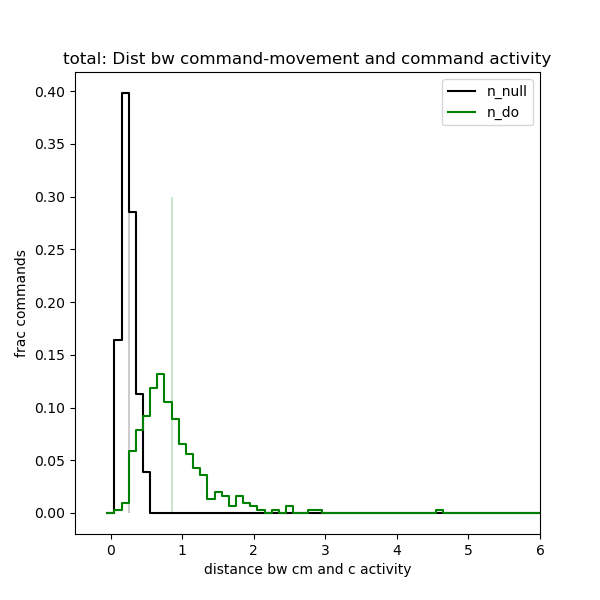

151
(304L,)
('n_null', 0.24785260891794822)
151
(304L,)
('n_do', 0.8611694378643545)


<IPython.core.display.Javascript object>


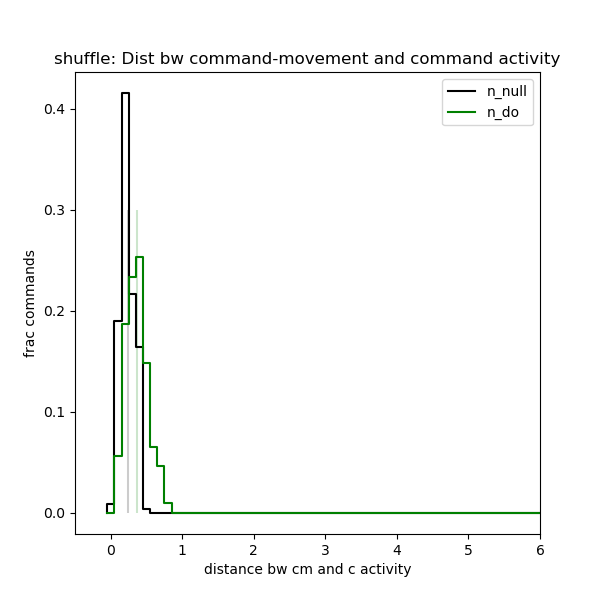

151
(304L,)
('n_null', 0.23720986073926123)
151
(304L,)
('n_do', 0.36861216346453535)


In [273]:
#Histogram the diffs and plot overlapping distributions:

# vmin = np.floor(np.min((np.min(model_diff['n_do'][diff_type]), np.min(model_diff['n_null'][diff_type])))) #0
# vmax = np.ceil(np.max((np.max(model_diff['n_do'][diff_type]), np.max(model_diff['n_null'][diff_type])))) #6

vmin=0
vmax=15
num_bins = (vmax-vmin)*10+1
for diff_type in ['total', 'shuffle']:

    
    cm_diff_bins_c = np.linspace(vmin,vmax,num_bins)
    bin_w = cm_diff_bins_c[1]-cm_diff_bins_c[0]
    cm_diff_bins_e = np.vstack((cm_diff_bins_c-bin_w/2, cm_diff_bins_c+bin_w/2))
    bin_dic = {0:cm_diff_bins_e}

    cm_diff_binned = {'n_do':[], 'n_null':[]}

    model_list = ['n_do', 'n_null']
    for model in model_list:
        d = np.array(model_diff[model][diff_type]).reshape((-1,1))
        bin_result, hist_result = bmi_b.bin_vec_data(d,bin_dic)
        cm_diff_binned[model] = hist_result


    model_color = {'n_do':'g', 'n_o':'r', 'n_null':'k'}    
    cm_diff_bins_e_flat = np.hstack((cm_diff_bins_e[0,:], cm_diff_bins_e[1,-1]))

    plt.figure(figsize=(6,6))
    for model,d in cm_diff_binned.items():
        d_plot = d/np.sum(d)
    #     d_plot = np.cumsum(d_plot)
        bmi_util.hist_step_plot(cm_diff_bins_e_flat, d_plot.squeeze(),color=model_color[model],label=model)

        d_mean = np.mean(model_diff[model][diff_type])
        plt.vlines(d_mean, 0, 0.3, color=model_color[model],alpha=0.2)
        print(model, d_mean)
    plt.xlim((-0.5,6))    
    plt.legend()    
    plt.xlabel('distance bw cm and c activity')
    plt.ylabel('frac commands')
    plt.title(diff_type + ': Dist bw command-movement and command activity')


<IPython.core.display.Javascript object>


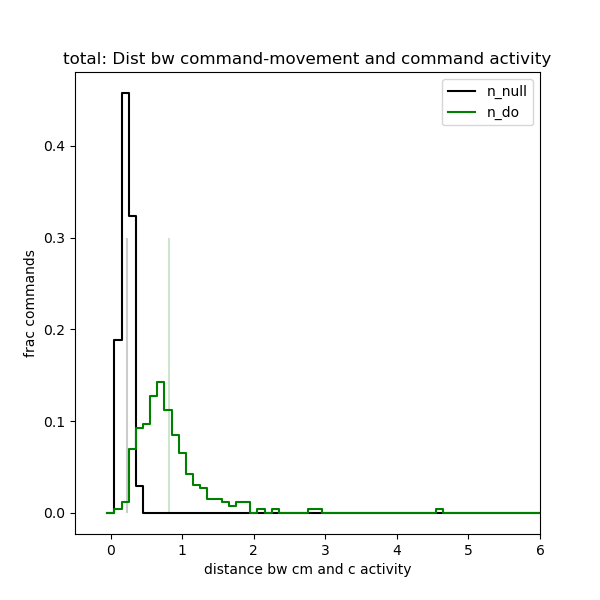

151
(304L,)
('n_null', 0.2220771647313285)
151
(304L,)
('n_do', 0.8112571454070493)


<IPython.core.display.Javascript object>


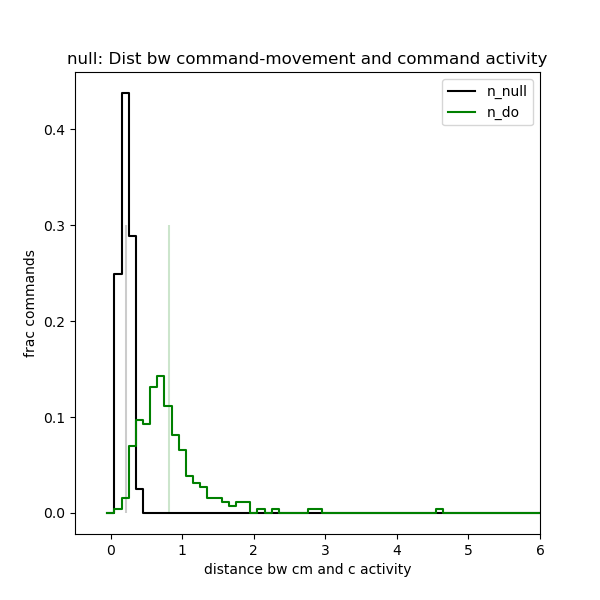

151
(304L,)
('n_null', 0.21129100217538618)
151
(304L,)
('n_do', 0.8072092235984824)


<IPython.core.display.Javascript object>


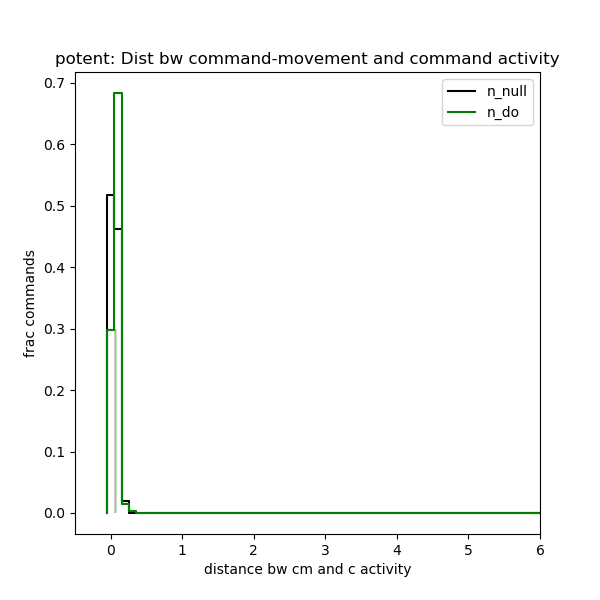

151
(304L,)
('n_null', 0.0584553456159177)
151
(304L,)
('n_do', 0.07017306465969327)


In [49]:
#Histogram the diffs and plot overlapping distributions:

# vmin = np.floor(np.min((np.min(model_diff['n_do'][diff_type]), np.min(model_diff['n_null'][diff_type])))) #0
# vmax = np.ceil(np.max((np.max(model_diff['n_do'][diff_type]), np.max(model_diff['n_null'][diff_type])))) #6

vmin=0
vmax=15
num_bins = (vmax-vmin)*10+1
for diff_type in ['total', 'null', 'potent']:

    
    cm_diff_bins_c = np.linspace(vmin,vmax,num_bins)
    bin_w = cm_diff_bins_c[1]-cm_diff_bins_c[0]
    cm_diff_bins_e = np.vstack((cm_diff_bins_c-bin_w/2, cm_diff_bins_c+bin_w/2))
    bin_dic = {0:cm_diff_bins_e}

    cm_diff_binned = {'n_do':[], 'n_null':[]}

    model_list = ['n_do', 'n_null']
    for model in model_list:
        d = np.array(model_diff[model][diff_type]).reshape((-1,1))
        bin_result, hist_result = bmi_b.bin_vec_data(d,bin_dic)
        cm_diff_binned[model] = hist_result


    model_color = {'n_do':'g', 'n_o':'r', 'n_null':'k'}    
    cm_diff_bins_e_flat = np.hstack((cm_diff_bins_e[0,:], cm_diff_bins_e[1,-1]))

    plt.figure(figsize=(6,6))
    for model,d in cm_diff_binned.items():
        d_plot = d/np.sum(d)
    #     d_plot = np.cumsum(d_plot)
        bmi_util.hist_step_plot(cm_diff_bins_e_flat, d_plot.squeeze(),color=model_color[model],label=model)

        d_mean = np.mean(model_diff[model][diff_type])
        plt.vlines(d_mean, 0, 0.3, color=model_color[model],alpha=0.2)
        print(model, d_mean)
    plt.xlim((-0.5,6))    
    plt.legend()    
    plt.xlabel('distance bw cm and c activity')
    plt.ylabel('frac commands')
    plt.title(diff_type + ': Dist bw command-movement and command activity')


In [274]:
#loop over all conditions, difference between both models:
model_m_diff = []
for ic, c in enumerate(c_list): #command    
    for im, m in enumerate(m_list): #movement
        if model_cm['n_do',c,m,'pool_match_success'] and model_cm['n_null',c,m,'pool_match_success']:  
            print(model_cm['n_do',c,m,'num_obs'], len(model_cm['n_do',c,m,'pool_match_idx']), model_cm['n_null',c,m,'num_obs'], len(model_cm['n_null',c,m,'pool_match_idx']))
            
            diff_i = model_cm['n_do',c,m,'n_diff_norm_true']-model_cm['n_null',c,m,'n_diff_norm_true']
            if not np.isnan(diff_i):
                model_m_diff.append(diff_i)

(121, 313, 137, 224)
(7, 392, 10, 449)
(8, 523, 6, 449)
(102, 287, 97, 179)
(11, 523, 9, 246)
(23, 523, 9, 449)
(8, 444, 9, 314)
(13, 523, 9, 449)
(16, 523, 20, 449)
(7, 392, 3, 449)
(14, 523, 16, 381)
(13, 470, 8, 291)
(12, 523, 11, 449)
(9, 523, 8, 246)
(2, 313, 6, 291)
(10, 392, 15, 336)
(8, 523, 8, 404)
(9, 523, 10, 291)
(11, 418, 5, 246)
(23, 523, 10, 381)
(16, 523, 12, 449)
(45, 366, 10, 291)
(23, 523, 16, 314)
(12, 523, 5, 449)
(14, 556, 8, 327)
(18, 500, 37, 409)
(16, 417, 17, 491)
(221, 389, 256, 382)
(12, 556, 11, 409)
(18, 556, 16, 354)
(54, 222, 41, 136)
(8, 278, 8, 464)
(12, 556, 14, 546)
(10, 472, 7, 327)
(25, 556, 13, 300)
(25, 528, 17, 245)
(11, 333, 6, 546)
(19, 444, 16, 546)
(6, 556, 14, 273)
(12, 556, 12, 546)
(4, 166, 5, 436)
(0, 556, 7, 245)
(12, 444, 7, 464)
(7, 556, 3, 546)
(8, 500, 8, 546)
(12, 333, 4, 546)
(17, 528, 6, 409)
(15, 556, 13, 436)
(4, 569, 4, 361)
(18, 569, 14, 361)
(7, 512, 16, 603)
(19, 569, 12, 331)
(29, 569, 19, 603)
(18, 569, 13, 603)
(281, 540

In [275]:
np.mean(model_m_diff)

0.5833688812413951

<IPython.core.display.Javascript object>


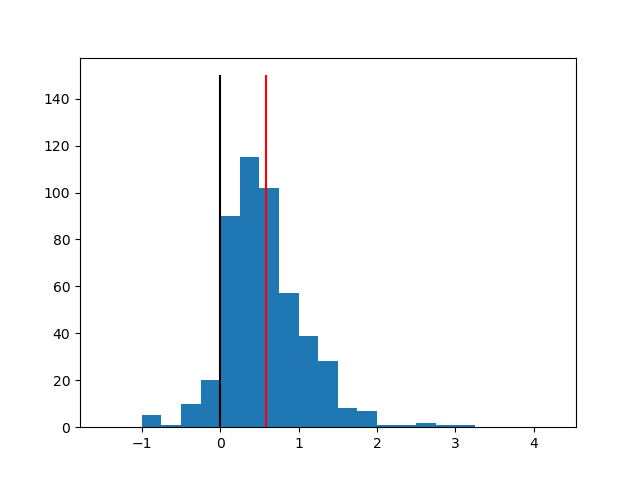

In [278]:
plt.figure()
_=plt.hist(model_m_diff, bins=np.arange(-1.5,4.5,.25))
plt.vlines(np.mean(model_m_diff), 0, 150, color='r')
plt.vlines(0, 0, 150, color='k')

In [100]:
save_path

'D:\\DATA\\bmi_co_obs_backup\\lqr_noise_20trials_noise_diag_from_noiseless_n_null_lqr.pkl'

In [277]:
#Save analysis results: 
r = {}
r['df_mean'] = df_mean
r['df_diff'] = df_diff
r['model_cm'] = model_cm
r['min_obs'] = min_obs
r['model_diff'] = model_diff
r['model_m_diff'] = model_m_diff


r['cm_diff_binned'] = cm_diff_binned
r['cm_diff_bins_e_flat'] = cm_diff_bins_e_flat

r['mag_bin'] = mag_bin
r['mag_bin_edges'] = mag_bin_edges
r['mag_bin_c'] = mag_bin_c
r['angle_bin_c'] = angle_bin_c
r['angle_bin'] = angle_bin
r['angle_bin_edges'] = angle_bin_edges
r['angle_center_for_binning'] = angle_center_for_binning
r['num_mag_bins_analyze'] = num_mag_bins_analyze

### Save noiseless lqr data: 
save_dir_backup = r'D:\DATA\bmi_co_obs_backup'
save_path = os.path.join(r'D:\DATA\bmi_co_obs_backup', 'analysis_lqr_noise_20trials_noise_diag_from_noiseless_n_null_lqr_1000_shuffle.pkl')
with open(save_path, 'wb') as f: 
    data = pickle.dump(r, f, protocol=pickle.HIGHEST_PROTOCOL)
    
    

### Check example command and movements

In [279]:
#assign to df, sloppy coding variable names.
df = df_lqr

In [107]:
model_list

['n_do', 'n_null']

In [108]:
for i in df.columns:
    print(i)

n_0
n_1
n_2
n_3
n_4
n_5
n_6
n_7
n_8
n_9
n_10
n_11
n_12
n_13
n_14
n_15
n_16
n_17
n_18
n_19
n_20
n_21
n_22
n_23
n_24
n_25
n_26
n_27
n_28
n_29
n_30
n_31
n_32
n_33
n_34
n_35
n_36
n_37
n_38
n_39
n_40
n_41
n_42
n_43
kin_px
kin_py
kin_vx
kin_vy
u_px
u_py
u_vx
u_vy
u_offset
u_0
u_1
u_2
u_3
u_4
u_5
u_6
u_7
u_8
u_9
u_10
u_11
u_12
u_13
u_14
u_15
u_16
u_17
u_18
u_19
u_20
u_21
u_22
u_23
u_24
u_25
u_26
u_27
u_28
u_29
u_30
u_31
u_32
u_33
u_34
u_35
u_36
u_37
u_38
u_39
u_40
u_41
u_42
u_43
task_rot
target
bin
bin_end
trial
model
p_mag
p_angle
v_mag
v_angle
u_p_mag
u_p_angle
u_v_mag
u_v_angle
u_v_mag_bin
u_v_angle_bin
p_angle_ctr_t
v_angle_ctr_t
u_p_angle_ctr_t
u_v_angle_ctr_t
u_v_angle_ctr_bin


In [687]:
#Identify movements + num_obs +sel for each command
#also save for each movement separately

bin_buffer = 5 #only count data after the first 5 samples and before the last 5 samples: 
min_obs = 15
cm_dic = {}
#Loop over command:
for model in model_list:
    for c in c_list: 
        bm = c[0]
        ba = c[1]

        cm_dic[model, c] = []
        cm_dic[model, c,'num_obs'] = []
        #Loop over movement: 
        for m in move_list:
            sel = \
            (df['model']==model) \
            &(df['target']==m[0]) \
            & (df['task_rot']==m[1]) \
            & (df['bin'] >= bin_buffer) \
            & (df['bin_end'] >= bin_buffer) \
            & (df['u_v_mag_bin'] == bm) \
            & (df['u_v_angle_bin'] == ba)
            num_obs = sum(sel)
    #             print(bm, ba, m, num_obs)
            #ASSIGN:
            cm_dic[model,c,m,'sel'] = sel
            cm_dic[model,c,m,'num_obs'] = num_obs
            if num_obs >= min_obs:
                cm_dic[model,c].append(m)
                cm_dic[model,c,'num_obs'].append(num_obs)
#Make the movement-pool sel: 
for model in model_list:
    for c in c_list:
        bm = c[0]
        ba = c[1]
        cm_dic[model, c, 'sel'] = np.zeros(df.shape[0]).astype('bool')
        for m in cm_dic[model,(bm,ba)]:
            cm_dic[model, c, 'sel'] = cm_dic[model, c, 'sel'] \
            | cm_dic[model, c,m,'sel']
    #movement-pool sel wil be useful as the global mean for command-activity.

In [688]:
num_m = len(m_list)
m2idx = {}
idx2m = {}
m2label={}
label2m={}
for i,m in enumerate(m_list):
    m2idx[m]=i
    idx2m[i]=m
    
    label = 'm_'+str(i)
    m2label[m] = label
    label2m[label] = m
    

num_c = len(c_list)
c2idx = {}
idx2c = {}
c2label={}
label2c={}
for i,c in enumerate(c_list):
    c2idx[c]=i
    idx2c[i]=c
    
    label = 'c_'+str(i)
    c2label[c] = label
    label2c[label] = c    

In [625]:
c_list

[(0, 0),
 (0, 1),
 (0, 2),
 (0, 3),
 (0, 4),
 (0, 5),
 (0, 6),
 (0, 7),
 (1, 0),
 (1, 1),
 (1, 2),
 (1, 3),
 (1, 4),
 (1, 5),
 (1, 6),
 (1, 7),
 (2, 0),
 (2, 1),
 (2, 2),
 (2, 3),
 (2, 4),
 (2, 5),
 (2, 6),
 (2, 7),
 (3, 0),
 (3, 1),
 (3, 2),
 (3, 3),
 (3, 4),
 (3, 5),
 (3, 6),
 (3, 7)]

In [689]:
### Example command: 
c = (1,1)

#(2,1)
#To Try: 
#(3,2)
#(1,7)

l1 = set(cm_dic['n_do', c])
m_analyze = list(l1.intersection(cm_dic['n_null', c]))

for model in model_list: 
    for m in m_analyze: 
        if not model_cm[model,c,m,'pool_match_success']:
            m_analyze.remove(m)

m_analyze

# for model in model_list:
#     m_analyze = cm_dic[model, c]
#     print(model, m_analyze)

[(0, 1.1), (1, 0), (3, 1.2), (3, 1.1), (0, 1.2)]

In [690]:
#loop movements, get the position psth, lag0 centered psth
#use all the observations of the command

bin_buffer_start = 5+1
bin_buffer_stop = 5
sel_b = (df['bin']>=bin_buffer_start)&(df['bin_end']>=bin_buffer_stop)


psth_var = ['kin_px', 'kin_py']
win = [-5,5]
psth_dic = {}
psth_list = []
psthc_list = []
for model in model_list: 
    psth_list = []
    psthc_list = []
    
#     m_analyze = cm_dic[model, c]
    print(model)
    for m in m_analyze: 
    #     idx = np.where(cm_dic[c,m,'sel'])[0]

        idx_sel = cm_dic[model, c,m,'sel']
        idx_sel_a = idx_sel & sel_b

        #---------------------------------------------------------------------------------------------------------------------
        idx_a = np.where(idx_sel_a)[0]#-1 #we need to delay the position by one lag for exptal analysis, not for lqr
        #---------------------------------------------------------------------------------------------------------------------

        print(m, idx_a)

        da, psth, psth_sem = bmi_b.df_idx_win2psth_mat(df.loc[:,psth_var], idx_a, win, psth_var)
        #center at lag0:
        psthc = psth-psth.loc[:,0]
        psth_list.append(psth)
        psthc_list.append(psthc)  
        
    psth_dic[model, 'psth_list'] = psth_list
    psth_dic[model, 'psthc_list'] = psthc_list
        

n_do
((0, 1.1), array([1622, 1624, 1710, 1784, 1786, 1855, 1857, 1893, 1894, 1903, 1934,
       2049, 2093, 2137, 2167, 2175, 2244, 2245, 2248, 2294, 2295, 2324,
       2325, 2330], dtype=int64))
((1, 0), array([4687, 4688, 4689, 4691, 4693, 4699, 4701, 4705, 4708, 4712, 4727,
       4728, 4731, 4732, 4742, 4743, 4745, 4746, 4749, 4751, 4765, 4768,
       4770, 4771, 4773, 4774, 4780, 4786, 4788, 4803, 4805, 4809, 4814,
       4819, 4821, 4825, 4827, 4846, 4848, 4851, 4853, 4865, 4866, 4867,
       4882, 4883, 4884, 4886, 4887, 4890, 4891, 4892, 4895, 4896, 4901,
       4920, 4921, 4928, 4933, 4934, 4936, 4938, 4939, 4946, 4961, 4968,
       4971, 4974, 4976, 4982, 4983, 4998, 5001, 5002, 5003, 5005, 5008,
       5009, 5012, 5018, 5020, 5022, 5023, 5039, 5042, 5043, 5044, 5046,
       5047, 5048, 5049, 5050, 5052, 5057, 5058, 5063, 5076, 5086, 5088,
       5090, 5091, 5092, 5096, 5098, 5116, 5117, 5118, 5121, 5122, 5125,
       5127, 5130, 5140, 5141, 5142, 5160, 5161, 5163, 5164, 5166

In [611]:
m_analyze

[(3, 0), (2, 0), (1, 1.1)]

In [614]:
c

(0, 3)

<IPython.core.display.Javascript object>


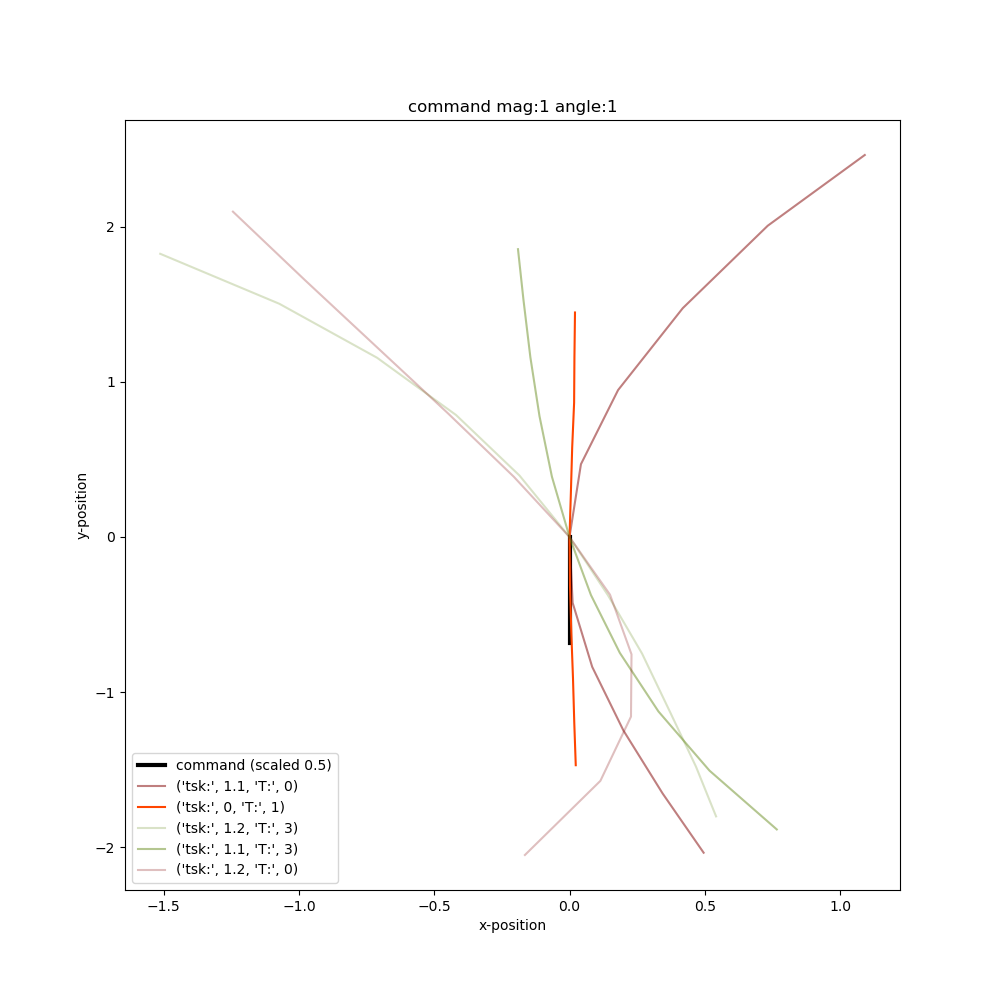

<IPython.core.display.Javascript object>


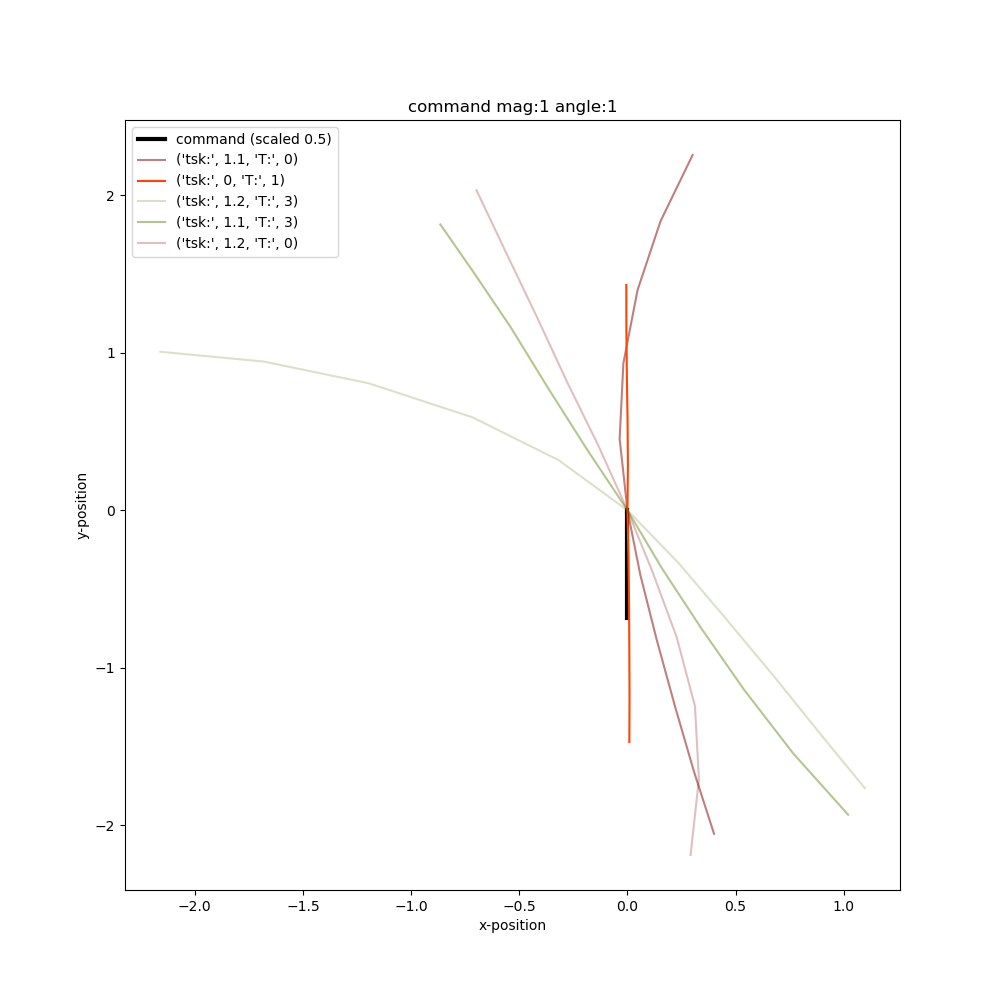

In [691]:
#PLOT the position PSTH

save_bool = False
for model in model_list:
    fig_name = model+'_command_locked_position_psth'
    psthc_list = psth_dic[model, 'psthc_list']
#     m_analyze = cm_dic[model, c]
    
    mag_bin = c[0]
    angle_bin = c[1]
    sc = 0.5

    pm = mag_bin_c[mag_bin]
    pa = angle_bin_c[angle_bin]
    x_bin = pm*np.cos(pa)*sc
    y_bin = pm*np.sin(pa)*sc

    # task_alpha = [1, 0.5]
    task_alpha_dic = {0:1, 1.1:0.5, 1.2:0.25}   #[1, 0.5, 0.25]
    plt.figure(figsize=(10,10))
    plt.plot([0, x_bin], [0, y_bin], color=np.ones(3)*0.0, linewidth=3, label='command (scaled ' + str(sc)+')')
    
        
    
    m_model = cm_dic[model, c]
    
    for i,psthc in enumerate(psthc_list):
        m = m_analyze[i]
#         m = m_model[i]
#         if m in m_analyze:
        

        task = m[1] #int(round(m[1]))
        target = int(m[0])
    #     plt.plot(psthc.loc['kin_px'], psthc.loc['kin_py'], '.-', alpha=task_alpha[task], color=target_color[target], label=('tsk:',m[1],'T:',target))
    #     plt.plot(psthc.loc['kin_px', win[1]], psthc.loc['kin_py', win[1]], '.-', color='r') #color=np.ones(3)*0.0
    #     plt.plot(psthc.loc['kin_px', win[0]], psthc.loc['kin_py', win[0]], '.-', color='g')  

        plt.plot(psthc.loc['kin_px'], psthc.loc['kin_py'], '-', alpha=task_alpha_dic[task], color=target_color[target], label=('tsk:',m[1],'T:',target))
#         plt.plot(psthc.loc['kin_px', win[1]], psthc.loc['kin_py', win[1]], '.-', color='r') #color=np.ones(3)*0.0
#         plt.plot(psthc.loc['kin_px', win[0]], psthc.loc['kin_py', win[0]], '.-', color='g')      


#     plt.xlim([-2.5, 2.5])
#     plt.ylim([-2.5, 2.5])
#     plt.axis('equal')
    plt.legend()
    plt.xlabel('x-position')
    plt.ylabel('y-position')
    plt.title('command mag:'+str(mag_bin) + ' angle:' + str(angle_bin))

    if save_bool:
        for ext in ext_list:
            plt.savefig(os.path.join(save_dir, fig_name+ext))

In [567]:
m_analyze

[(2, 1.1), (3, 1.2), (0, 1.2), (0, 1.1), (2, 1.2), (3, 1.1), (1, 0)]

In [575]:
c

(2, 1)

In [630]:
c

(0, 3)

((0, 1.1), 31)
((1, 0), 245)
((3, 1.2), 62)
((3, 1.1), 78)
((0, 1.2), 38)


<IPython.core.display.Javascript object>


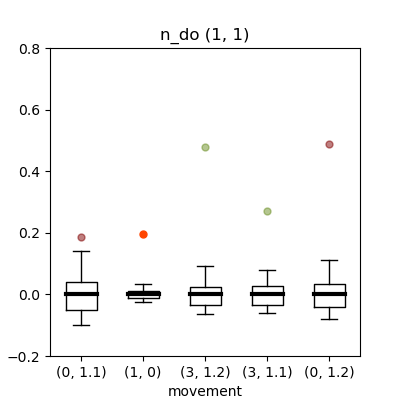

((0, 1.1), 76)
((1, 0), 237)
((3, 1.2), 31)
((3, 1.1), 39)
((0, 1.2), 82)


<IPython.core.display.Javascript object>


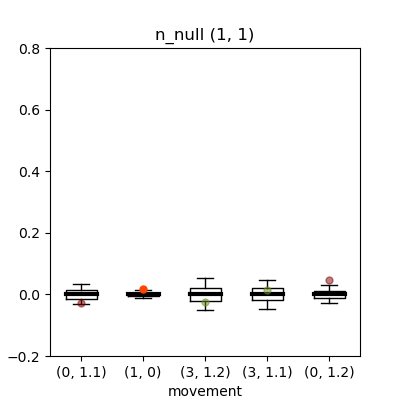

In [694]:
save_bool = False
figsize=(4,4)

center_bool = True

for model in model_list: 
    fig_name = model+'_neural_command_diff' 
#     m_analyze = cm_dic[model, c]

    d_plt = []
    s_list = []
    for i,m in enumerate(m_analyze):    
        d = model_cm[model,c,m,'n_diff_norm_true']
        s = model_cm[model,c,m,'n_diff_s_norm_mean']
        
        if center_bool:
            d_diff = d-s
        else:
            d_diff = d
        d_plt.append(d_diff)
        
        if center_bool:
            s_list.append(model_cm[model,c,m,'n_diff_s_norm']-s)
        else: 
            s_list.append(model_cm[model,c,m,'n_diff_s_norm'])

        print(m, model_cm[model,c,m,'num_obs'])
    #     plt.plot(i, model_cm[model,c,m,'n_diff_norm_true']

    medianprops=dict(linewidth=0)
    meanprops=dict(linestyle='-',linewidth=3,color='k')
#     whis=[2.5,97.5]
    whis=[5,95]
    fig,ax=plt.subplots(figsize=figsize)
    _=plt.boxplot(s_list,whis=whis, meanline=True, showmeans=True, medianprops=medianprops, meanprops=meanprops, showfliers=False) #showfliers=True



    for i,m in enumerate(m_analyze):
#         task = int(round(m[1]))
        task = m[1]
        target = int(m[0])    
        plt.plot(i+1, d_plt[i], '.', markersize=10, alpha=task_alpha[task], color=target_color[target], label=('tsk:',task,'T:',target), zorder=1000)

    x_plt = np.arange(len(d_plt))+1
    # # plt.scatter(x_plt, d_plt, color='r', label='data mean')

    plt.xticks(x_plt, m_analyze)
    plt.xlabel('movement')
    ylabel_str = 'population-average activity difference, centered by shuffle mean'
    plt.ylabel(ylabel_str)
    plt.title(model + ' ' + str(c))
    if center_bool:
        plt.ylim([-0.2, 0.8])
    # plt.legend()


    if save_bool:
        for ext in ext_list:
            plt.savefig(os.path.join(save_dir, fig_name+ext))

In [ ]:
 model_cm[model,c,m,'pool_match_success']

In [444]:
m_analyze

[(2, 1.1), (3, 1.2), (0, 1.2), (0, 1.1), (2, 1.2), (3, 1.1), (1, 0)]

### Visualize activity in PC space: 

TODO: 
take each m in m_analyze, and try to match them to the pool of m_analyze
repeat the stats from above on this data.  


In [697]:
#Data matrix

command_match = False
model_pc = {}
for model in model_list:
    d = []
    for m in m_analyze: 
#         di = np.dot(P_null, model_cm[model,c,m,'n_cm']-model_cm[model,c,m,'n_c'])
        if command_match: 
            di = model_cm[model,c,m,'n_cm']-model_cm[model,c,m,'n_c']
        else: 
            di = model_cm[model,c,m,'n_cm']
        d.append(np.array(di).reshape((-1,1)))  
    model_pc[model, 'data_mat'] = np.concatenate(d, axis=1)
    model_pc[model, 'mean'] = np.mean(model_pc[model, 'data_mat'], axis=1)
    model_pc[model, 'data_mat_c'] = model_pc[model, 'data_mat'] - model_pc[model, 'mean'].reshape((-1,1))
    u,s,vh = np.linalg.svd(model_pc[model, 'data_mat_c'])  
    model_pc[model, 'pc'] = u
    

In [683]:
# #Projection into decoder null space
# Kn2v = Kn[2:4,:]
# u,s,vh = np.linalg.svd(Kn2v)
# vh_trunc = vh[:2,:]
# P = np.dot(vh_trunc.T,vh_trunc)
# P_null = np.eye(num_neurons)-P

<IPython.core.display.Javascript object>


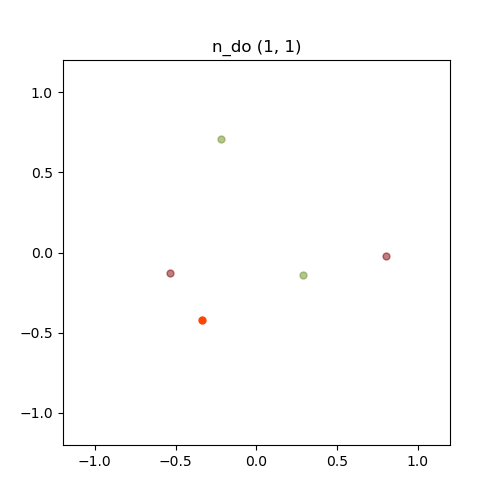

<IPython.core.display.Javascript object>


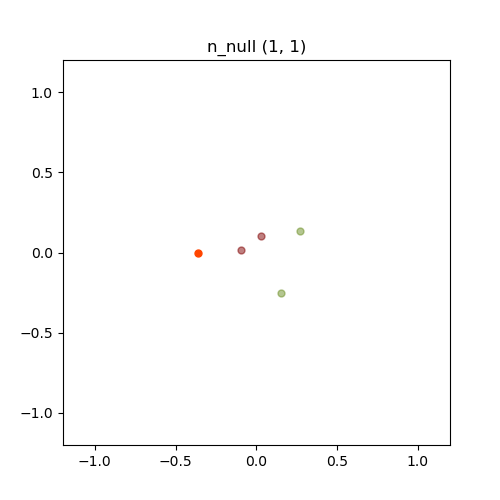

In [698]:
#TODO project into PCA space: 

#For each model:
#solve for the pc space
#project the average for each condition
#draw the shuffle

for model in model_list: 
    fig_name = model+'_PC_command' 
    plt.figure(figsize=(5,5))
    ax = plt.gca()
    for m in m_analyze: 
        task = m[1]
        target = int(m[0]) 
        
        #DATA: 
        if command_match: 
            d_cm = np.array(model_cm[model,c,m,'n_cm'])-np.array(model_cm[model,c,m,'n_c'])-model_pc[model, 'mean']
        else:
            d_cm = np.array(model_cm[model,c,m,'n_cm'])-model_pc[model, 'mean']            
            
#         mu_cm = np.dot(P_null, model_cm[model,c,m,'n_cm']- model_cm[model,c,m,'n_c'])
        d_cm_pc = np.dot(model_pc[model, 'pc'][:,0:2].T, d_cm)
        plt.plot(d_cm_pc[0], d_cm_pc[1], '.',  markersize=10, alpha=task_alpha[task], color=target_color[target], label=('tsk:',task,'T:',target))
        
#         #SHUFFLE: 
#         s = model_cm[model,c,m,'n_s'] - np.array(model_cm[model,c,m,'n_c'])[:,None]
#         s_pc = np.dot(model_pc[model][:,0:2].T, s)
        
#         bmi_util.confidence_ellipse(s_pc[0,:], s_pc[1,:], ax, n_std=3.0, facecolor='none', edgecolor='k')
        
    
    plt.title(model + ' ' + str(c))
    
    plt.xlim([-1.2, 1.2])
    plt.ylim([-1.2,1.2])
#     plt.legend()





In [ ]:
#for the chosen command and movements, show the activity differences: 
model = 'n_do'
c = (1,2)

plt.figure(figsize=(5,5))
for i,m in enumerate(m_analyze):
    task = int(round(m[1]))
    target = int(m[0])    
    plt.plot(i, model_cm[model,c,m,'n_diff_norm_true'], '.', markersize=10, alpha=task_alpha[task], color=target_color[target], label=('tsk:',task,'T:',target))
    
    plt.plot(i, model_cm[model,c,m,'n_diff_s_norm_mean'], '.', alpha=task_alpha[task], color=target_color[target], label=('tsk:',task,'T:',target))    
model_cm[model,c,m,'n_diff_s_norm_mean']    


In [420]:
model_cm.keys()

[('n_do', (1, 6), (0, 0), 'n_diff_true'),
 ('n_do', (0, 1), (4, 1.1), 'sel'),
 ('n_null', (0, 0), (1, 1.1), 'sel'),
 ('n_do', (1, 1), (4, 1.1), 'pool_match_mean'),
 ('n_null', (2, 5), (6, 1.1), 'n_diff_norm_true'),
 ('n_do', (3, 5), (5, 1.1), 'n_s'),
 ('n_do', (3, 0), (7, 0), 'num_obs'),
 ('n_do', (3, 5), (1, 1.1), 'num_obs'),
 ('n_null', (0, 1), (6, 1.1), 'n_diff_norm_null'),
 ('n_null', (1, 3), (0, 0), 'pool_match_mean'),
 ('n_null', (3, 6), (4, 1.2), 'n_diff_norm_null'),
 ('n_do', (2, 7), (2, 1.1), 'n_diff_true'),
 ('n_null', (0, 2), 'sel'),
 ('n_do', (3, 3), (1, 1.1), 'n_diff_norm_true'),
 ('n_null', (1, 6), (5, 0), 'n_s'),
 ('n_do', (3, 0), (2, 1.2), 'n_c'),
 ('n_null', (3, 7), (7, 0), 'n_diff_norm_null'),
 ('n_null', (3, 1), (2, 0), 'n_c'),
 ('n_do', (0, 2), (5, 1.1), 'pool_match_success'),
 ('n_do', (3, 0), (5, 0), 'num_obs'),
 ('n_null', (1, 2), (0, 1.1), 'n_diff_norm_null'),
 ('n_do', (2, 1), (4, 1.2), 'sel'),
 ('n_null', (3, 4), (0, 1.2), 'n_s'),
 ('n_do', (3, 1), (7, 0), 'se

In [416]:
nm.shape

(18720L, 44L)

In [ ]:
save_bool = True
for model in model_list: 
    fig_name = model+'_neural_command_diff' 
#     m_analyze = cm_dic[model, c]

    d_plt = []
    s_list = []
    for i,m in enumerate(m_analyze):    
        d = model_cm[model,c,m,'n_diff_norm_true']
        s = model_cm[model,c,m,'n_diff_s_norm_mean']
        d_diff = d-s
        d_plt.append(d_diff)
        s_list.append(model_cm[model,c,m,'n_diff_s_norm']-s)

        print(m, model_cm[model,c,m,'num_obs'])
    #     plt.plot(i, model_cm[model,c,m,'n_diff_norm_true']

    medianprops=dict(linewidth=0)
    meanprops=dict(linestyle='-',linewidth=3,color='k')
#     whis=[2.5,97.5]
    whis=[5,95]
    fig,ax=plt.subplots(figsize=(7,7))
    _=plt.boxplot(s_list,whis=whis, meanline=True, showmeans=True, medianprops=medianprops, meanprops=meanprops, showfliers=False) #showfliers=True



    for i,m in enumerate(m_analyze):
#         task = int(round(m[1]))
        task = m[1]
        target = int(m[0])    
        plt.plot(i+1, d_plt[i], '.', markersize=10, alpha=task_alpha[task], color=target_color[target], label=('tsk:',task,'T:',target), zorder=1000)

    x_plt = np.arange(len(d_plt))+1
    # # plt.scatter(x_plt, d_plt, color='r', label='data mean')

    plt.xticks(x_plt, m_analyze)
    plt.xlabel('movement')
    ylabel_str = 'population-average activity difference, centered by shuffle mean'
    plt.ylabel(ylabel_str)
    plt.title('whiskers 5, 95')
    plt.ylim([-0.2, 0.75])
    # plt.legend()


    if save_bool:
        for ext in ext_list:
            plt.savefig(os.path.join(save_dir, fig_name+ext))

### Check random noise

In [216]:
state_noise_cov

array([[1.45588168, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.47058897, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.02206744, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [220]:
state_noise = np.random.multivariate_normal(mean=state_noise_mean, cov=state_noise_cov,size=2)

In [221]:
state_noise.shape

(2L, 49L)

In [228]:
test = state_noise.mean(axis=0)

In [229]:
test

array([-4.52571354e-01,  2.68406636e-01,  7.00899928e-02,  1.23338991e-01,
       -5.93952502e-01, -1.24835084e-01, -4.30219338e-01,  2.56721399e-01,
        4.94665532e-02, -5.89626503e-03,  1.44635663e-02,  1.18731119e+00,
       -2.78423656e-01,  1.52215434e-01,  2.67061935e-01,  1.16350467e+00,
       -1.05860690e+00,  5.21489741e-01, -1.14570080e+00,  1.98053090e-01,
       -7.73085200e-01, -9.65958092e-02,  1.17235330e+00,  6.47925437e-01,
        4.81799484e-01, -2.26109187e-01,  8.41781039e-01,  9.45040544e-01,
        2.24162549e-01, -8.32709733e-02,  2.03481844e-01, -9.57090638e-01,
        4.56244163e-01, -6.08984617e-01, -1.88476005e-01,  7.09748741e-01,
        1.39070545e+00,  2.00453292e+00,  1.23764473e+00,  8.17579334e-01,
        8.75809531e-01,  1.14269286e+00,  1.07579241e+00,  2.19124492e-01,
        1.24198915e-08, -2.08741049e-08, -4.95553121e-09,  4.19825913e-08,
       -1.81821844e-09])

In [226]:
c = (0,0)
m = (0,0)
print(model_cm[model,c,m,'num_obs'])
print(len(model_cm[model,c,m,'pool_match_idx']))

2322
13123


In [237]:
#loop over all conditions, collect a list of differences:
# model_diff = {'n_do':[], 'n_null':[]}
noise_diff = {}
for model in model_list: #model
    noise_diff[model] = []
    for ic, c in enumerate(c_list): #command    
        for im, m in enumerate(m_list): #movement
            if model_cm[model,c,m,'pool_match_success']:  
                #num_obs_c
                #num_obs_cm
                num_obs_c = len(model_cm[model,c,m,'pool_match_idx'])
                num_obs_cm = model_cm[model,c,m,'num_obs']
                
                #Generate the noise
                c_noise = np.random.multivariate_normal(mean=state_noise_mean[:num_neurons], cov=state_noise_cov[:num_neurons, :num_neurons],size=num_obs_c).T
                cm_noise = np.random.multivariate_normal(mean=state_noise_mean[:num_neurons], cov=state_noise_cov[:num_neurons, :num_neurons],size=num_obs_cm).T
                #calculate mean
                mu_c = c_noise.mean(axis=1)
                mu_cm = cm_noise.mean(axis=1)
                diff_i = mu_c-mu_cm
                #project the diff
                diff_potent_i, diff_null_i, _ = bmi_util.proj_null_potent(Kn[2:4,:].T, np.array(diff_i).reshape((-1,1)))
                norm_diff_null_i = np.linalg.norm(diff_null_i)
                noise_diff[model].append(norm_diff_null_i)

<IPython.core.display.Javascript object>


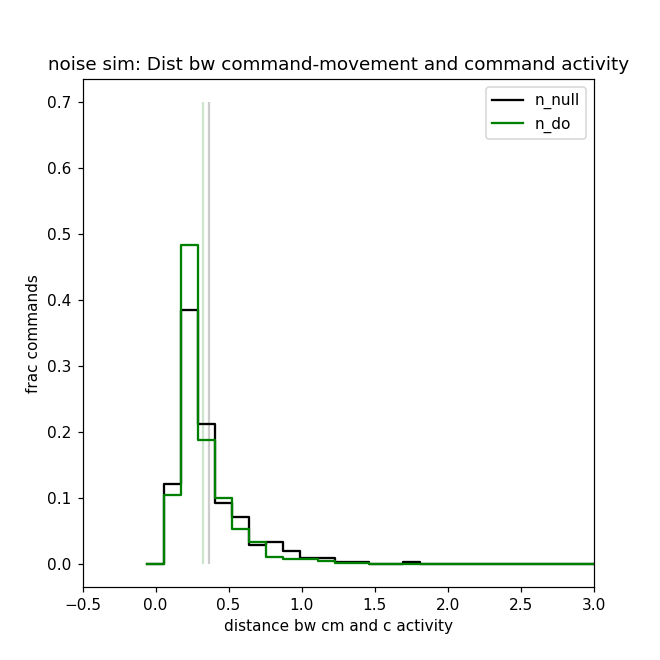

61
(124L,)
61
(124L,)


Text(0.5,1,'noise sim: Dist bw command-movement and command activity')

In [244]:
#Histogram the diffs and plot overlapping distributions:

# vmin = np.floor(np.min((np.min(model_diff['n_do'][diff_type]), np.min(model_diff['n_null'][diff_type])))) #0
# vmax = np.ceil(np.max((np.max(model_diff['n_do'][diff_type]), np.max(model_diff['n_null'][diff_type])))) #6

vmin=0
vmax=3
num_bins = (vmax-vmin)*20+1

    
cm_diff_bins_c = np.linspace(0,7,num_bins)
bin_w = cm_diff_bins_c[1]-cm_diff_bins_c[0]
cm_diff_bins_e = np.vstack((cm_diff_bins_c-bin_w/2, cm_diff_bins_c+bin_w/2))
bin_dic = {0:cm_diff_bins_e}

cm_diff_binned = {'n_do':[], 'n_null':[]}

model_list = ['n_do', 'n_null']
for model in model_list:
    d = np.array(noise_diff[model]).reshape((-1,1))
    bin_result, hist_result = bmi_b.bin_vec_data(d,bin_dic)
    cm_diff_binned[model] = hist_result


model_color = {'n_do':'g', 'n_o':'r', 'n_null':'k'}    
cm_diff_bins_e_flat = np.hstack((cm_diff_bins_e[0,:], cm_diff_bins_e[1,-1]))

plt.figure(figsize=(6,6))
for model,d in cm_diff_binned.items():
    d_plot = d/np.sum(d)
#     d_plot = np.cumsum(d_plot)
    bmi_util.hist_step_plot(cm_diff_bins_e_flat, d_plot.squeeze(),color=model_color[model],label=model)

    d_mean = np.mean(noise_diff[model])
    plt.vlines(d_mean, 0, 0.7, color=model_color[model],alpha=0.2)
plt.xlim((-0.5,vmax))    
plt.legend()    
plt.xlabel('distance bw cm and c activity')
plt.ylabel('frac commands')
plt.title('noise sim: Dist bw command-movement and command activity')


### Check how predictable neural activity is

In [ ]:
n_list = ['n_'+ str(i) for i in np.arange(num_neurons)]

### Dynamics model, use A

In [ ]:
m = 'n_do'

sel_m = (df_lqr['model']==m)

sel_t_bin = (df_lqr['bin'] >= 0)
sel_t_bin_end = (df_lqr['bin_end'] >= 1)
sel_t = (sel_t_bin)&(sel_t_bin_end)&sel_m
n_t = np.array(df_lqr.loc[sel_t,n_list]).T

sel_tp1_bin = (df_lqr['bin'] >= 1)
sel_tp1_bin_end = (df_lqr['bin_end'] >= 0)
sel_tp1 = (sel_tp1_bin)&(sel_tp1_bin_end)&sel_m
n_tp1 = np.array(df_lqr.loc[sel_tp1,n_list]).T

nhat_tp1 = np.dot(An, n_t)+ bn.reshape((-1,1))


#sanity check we can use the dynamics parameters:
total_cov = np.cov(n_tp1)
total_var = np.trace(total_cov)

res_hat = nhat_tp1-n_tp1 #44 x num_obs
res_cov = np.cov(res_hat) #44 x 44
res_var = np.trace(res_cov)

pred_cov = np.cov(nhat_tp1)
pred_var = np.trace(pred_cov)

print('sanity check on neural dynamics fit:')
print('model A R2: ', 1-res_var/total_var)
# print('true R2: ', clf.score(n_t, n_tp1))

In [ ]:
n_t.shape

In [ ]:
#expected number of samples
1000*38*8*3

### Dynamics model, fit new A, b

In [ ]:
m = 'n_do'

sel_m = (df_lqr['model']==m)

sel_t_bin = (df_lqr['bin'] >= 0)
sel_t_bin_end = (df_lqr['bin_end'] >= 1)
sel_t = (sel_t_bin)&(sel_t_bin_end)&sel_m
n_t = np.array(df_lqr.loc[sel_t,n_list]).T

sel_tp1_bin = (df_lqr['bin'] >= 1)
sel_tp1_bin_end = (df_lqr['bin_end'] >= 0)
sel_tp1 = (sel_tp1_bin)&(sel_tp1_bin_end)&sel_m
n_tp1 = np.array(df_lqr.loc[sel_tp1,n_list]).T


# regression: 
#ridge parameter from Preeya: 2500
clf = Ridge(alpha=1)
clf.fit(n_t.T, n_tp1.T)

An_fit = clf.coef_
bn_fit = clf.intercept_

print('fit A R2: ', clf.score(n_t.T, n_tp1.T))

### No dynamics model, fit new A, b

In [ ]:
m = 'n_null'

sel_m = (df_lqr['model']==m)

sel_t_bin = (df_lqr['bin'] >= 0)
sel_t_bin_end = (df_lqr['bin_end'] >= 1)
sel_t = (sel_t_bin)&(sel_t_bin_end)&sel_m
n_t = np.array(df_lqr.loc[sel_t,n_list]).T

sel_tp1_bin = (df_lqr['bin'] >= 1)
sel_tp1_bin_end = (df_lqr['bin_end'] >= 0)
sel_tp1 = (sel_tp1_bin)&(sel_tp1_bin_end)&sel_m
n_tp1 = np.array(df_lqr.loc[sel_tp1,n_list]).T

clf = Ridge(alpha=1)
clf.fit(np.array(n_t).T, np.array(n_tp1).T)

An_fit_null = clf.coef_
bn_fit_null = clf.intercept_

print('fit A R2: ', clf.score(n_t.T, n_tp1.T))

In [ ]:
n_t.shape

### Sanity check that simulated neural activity produces a command which does belong in the bin we've assigned it

In [ ]:
#let's just check at random

In [250]:
list(df_lqr.columns)

['n_0',
 'n_1',
 'n_2',
 'n_3',
 'n_4',
 'n_5',
 'n_6',
 'n_7',
 'n_8',
 'n_9',
 'n_10',
 'n_11',
 'n_12',
 'n_13',
 'n_14',
 'n_15',
 'n_16',
 'n_17',
 'n_18',
 'n_19',
 'n_20',
 'n_21',
 'n_22',
 'n_23',
 'n_24',
 'n_25',
 'n_26',
 'n_27',
 'n_28',
 'n_29',
 'n_30',
 'n_31',
 'n_32',
 'n_33',
 'n_34',
 'n_35',
 'n_36',
 'n_37',
 'n_38',
 'n_39',
 'n_40',
 'n_41',
 'n_42',
 'n_43',
 'kin_px',
 'kin_py',
 'kin_vx',
 'kin_vy',
 'u_px',
 'u_py',
 'u_vx',
 'u_vy',
 'u_offset',
 'u_0',
 'u_1',
 'u_2',
 'u_3',
 'u_4',
 'u_5',
 'u_6',
 'u_7',
 'u_8',
 'u_9',
 'u_10',
 'u_11',
 'u_12',
 'u_13',
 'u_14',
 'u_15',
 'u_16',
 'u_17',
 'u_18',
 'u_19',
 'u_20',
 'u_21',
 'u_22',
 'u_23',
 'u_24',
 'u_25',
 'u_26',
 'u_27',
 'u_28',
 'u_29',
 'u_30',
 'u_31',
 'u_32',
 'u_33',
 'u_34',
 'u_35',
 'u_36',
 'u_37',
 'u_38',
 'u_39',
 'u_40',
 'u_41',
 'u_42',
 'u_43',
 'task_rot',
 'target',
 'bin',
 'bin_end',
 'trial',
 'model',
 'p_mag',
 'p_angle',
 'v_mag',
 'v_angle',
 'u_p_mag',
 'u_p_angle',
 

In [262]:
i = 2
n_i = np.array(df_lqr.loc[i,n_list])

In [267]:
np.dot(Kn[2:4,:], n_i)

array([-2.4271086034399585, -0.7949223958911065], dtype=object)

n_0     -0.236848
n_1       1.56874
n_2     -0.308747
n_3      0.293642
n_4      0.466269
n_5       3.71036
n_6        2.1267
n_7      0.159832
n_8      0.319203
n_9     -0.256693
n_10     0.191119
n_11      2.81458
n_12     0.316477
n_13    0.0440328
n_14      2.43059
n_15     0.970835
n_16    -0.866493
n_17     0.336634
n_18      1.39709
n_19     0.360103
n_20    -0.996095
n_21      2.12807
n_22     0.747325
n_23      2.03558
n_24     0.117529
n_25       1.5247
n_26   -0.0486241
n_27      1.53866
n_28     0.778648
n_29   -0.0149233
n_30      2.96457
n_31     0.687934
n_32      1.29482
n_33    0.0728376
n_34    -0.654322
n_35     0.858668
n_36      1.80415
n_37    -0.990958
n_38      1.46305
n_39      2.43559
n_40    -0.272148
n_41      1.48296
n_42      1.05468
n_43      1.84248
Name: 100000, dtype: object
u_vx     -1.2299
u_vy    0.159042
Name: 100000, dtype: object
[-1.229898138927324 0.15904186904610493]
u_v_mag      1.24014
u_v_angle    3.01299
Name: 100000, dtype: object
u_v_mag

<IPython.core.display.Javascript object>


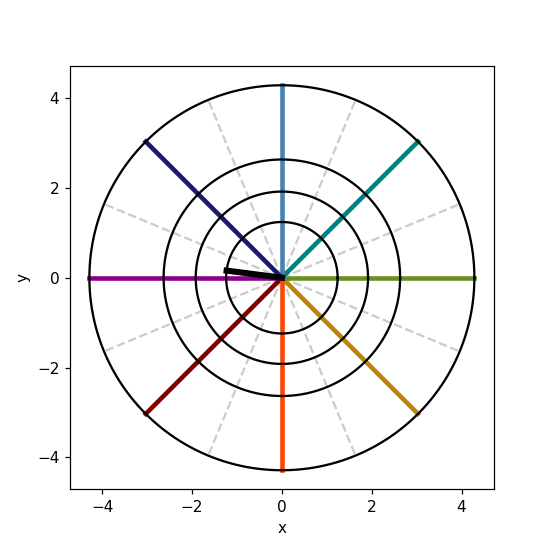

In [270]:
i = 100000
n_i = np.array(df_lqr.loc[i,n_list])
u_test = np.dot(Kn[2:4,:], n_i)
print(df_lqr.loc[i,n_list])
print(df_lqr.loc[i,['u_vx', 'u_vy']])
print(u_test)
print(df_lqr.loc[i,['u_v_mag', 'u_v_angle']])
print(df_lqr.loc[i,['u_v_mag_bin', 'u_v_angle_bin']])
plt.figure(figsize=(5,5))
plot_command_bin()
plt.plot([0,df_lqr.loc[i,'u_vx']], [0,df_lqr.loc[i,'u_vy']], 'k', linewidth=4)

In [253]:
print(angle_bin_edges)
print(mag_bin_edges[:,:(num_mag_bins_analyze)])

[[-2.74889357 -1.96349541 -1.17809725 -0.39269908  0.39269908  1.17809725
   1.96349541  2.74889357]
 [-1.96349541 -1.17809725 -0.39269908  0.39269908  1.17809725  1.96349541
   2.74889357  3.53429174]]
[[0.         1.24112374 1.91851102 2.63274708]
 [1.24112374 1.91851102 2.63274708 4.2855827 ]]


### Sanity check: visualize the activity for command pool and some command-movements... 

In [274]:
c_list

[(0, 0),
 (0, 1),
 (0, 2),
 (0, 3),
 (0, 4),
 (0, 5),
 (0, 6),
 (0, 7),
 (1, 0),
 (1, 1),
 (1, 2),
 (1, 3),
 (1, 4),
 (1, 5),
 (1, 6),
 (1, 7),
 (2, 0),
 (2, 1),
 (2, 2),
 (2, 3),
 (2, 4),
 (2, 5),
 (2, 6),
 (2, 7),
 (3, 0),
 (3, 1),
 (3, 2),
 (3, 3),
 (3, 4),
 (3, 5),
 (3, 6),
 (3, 7)]

In [275]:
m_list

[(0, 0),
 (0, 1.1),
 (0, 1.2),
 (1, 0),
 (1, 1.1),
 (1, 1.2),
 (2, 0),
 (2, 1.1),
 (2, 1.2),
 (3, 0),
 (3, 1.1),
 (3, 1.2),
 (4, 0),
 (4, 1.1),
 (4, 1.2),
 (5, 0),
 (5, 1.1),
 (5, 1.2),
 (6, 0),
 (6, 1.1),
 (6, 1.2),
 (7, 0),
 (7, 1.1),
 (7, 1.2)]

In [276]:
model='n_null'
c = (2,0)
m = (2,0)

sel_model = df_lqr['model']==model
sel_cm = df_lqr['u_v_mag_bin']==c[0]
sel_ca = df_lqr['u_v_angle_bin']==c[1]
sel_target = df_lqr['target']==m[0]
sel_task = df_lqr['task_rot']==m[1]

sel = sel_model&sel_cm&sel_ca&sel_target&sel_task

In [277]:
n_df = df_lqr.loc[sel,n_list]

In [278]:
n_df.shape

(412, 44)